In [4]:
from utilsTrainTest import visualize_reconstructionG3D
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchDatasets as ds
import matplotlib.pyplot as plt
import torch as T
from scipy.optimize import curve_fit
side = 10
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['figure.dpi']= 300
class ConvAutoencoder(nn.Module):
    def __init__(self, channelMult=8, dropout=0.2):
        super(ConvAutoencoder, self).__init__()
        # ----- Encoder -----
        self.encoder = nn.Sequential(
            nn.Conv3d(1, channelMult, kernel_size=3, stride=2, padding=1),  # -> (16, H/2, W/2)
            nn.BatchNorm3d(channelMult),
            nn.ReLU(True),

            nn.Dropout(dropout),
            nn.Conv3d(channelMult, 2*channelMult, kernel_size=3, stride=2, padding=1), # -> (8, H/4, W/4)
            nn.BatchNorm3d(2*channelMult),
            nn.ReLU(True)
        )

        # ----- Decoder -----
        self.decoder = nn.Sequential(
            nn.Dropout(dropout),
            nn.ConvTranspose3d(2*channelMult, channelMult, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (8, H/4, W/4)
            nn.BatchNorm3d(channelMult),
            nn.ReLU(True),

            nn.Dropout(dropout),
            nn.ConvTranspose3d(channelMult, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (16, H/2, W/2)
            nn.Sigmoid()  # keeps output in [0,1] for binary images
        )

    def forward(self, x):
        # Encode
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ConvAutoencoder(16, 0.2)
device = "cpu"
if T.cuda.is_available():
    device = "cuda"
batchSize = 100
dataDir = '/home/shashank/Code/gonihedric/data/ghData/'

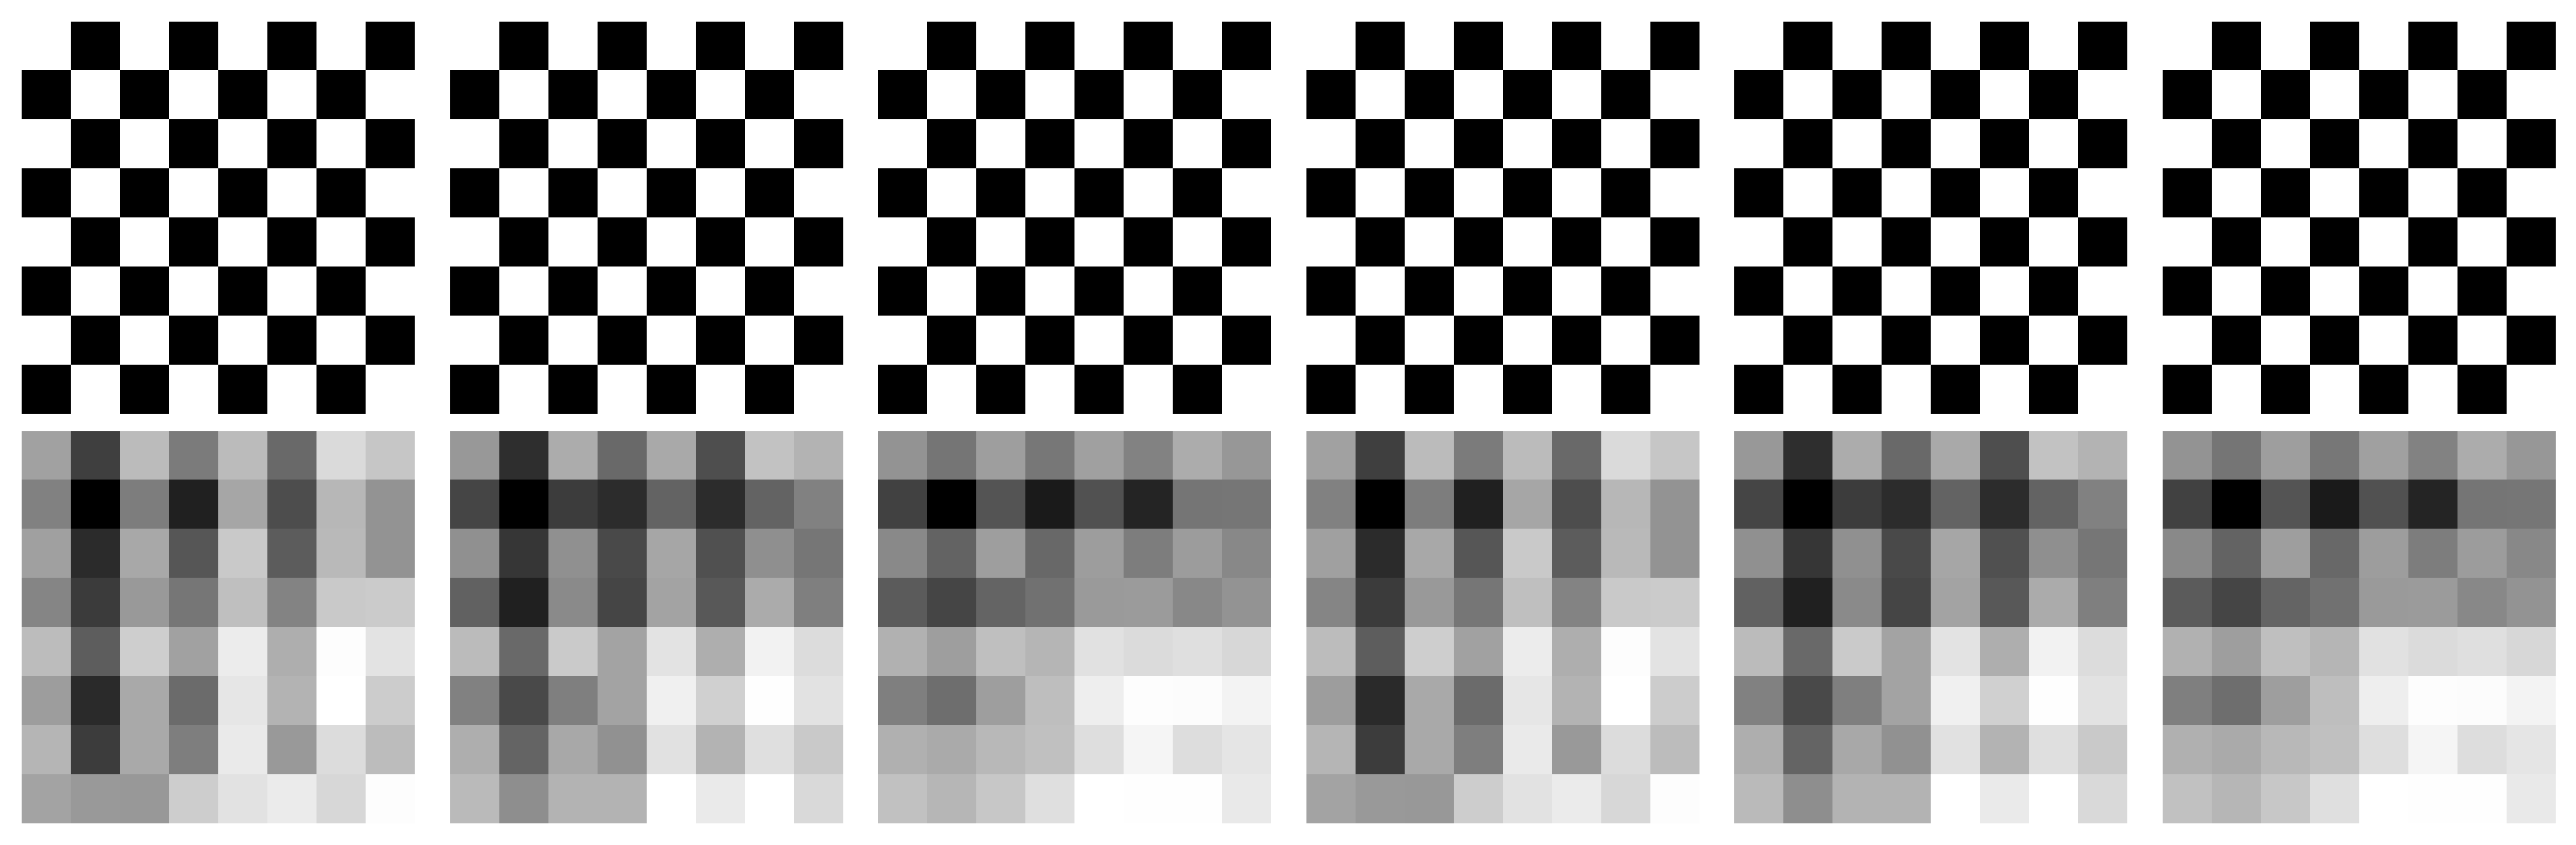

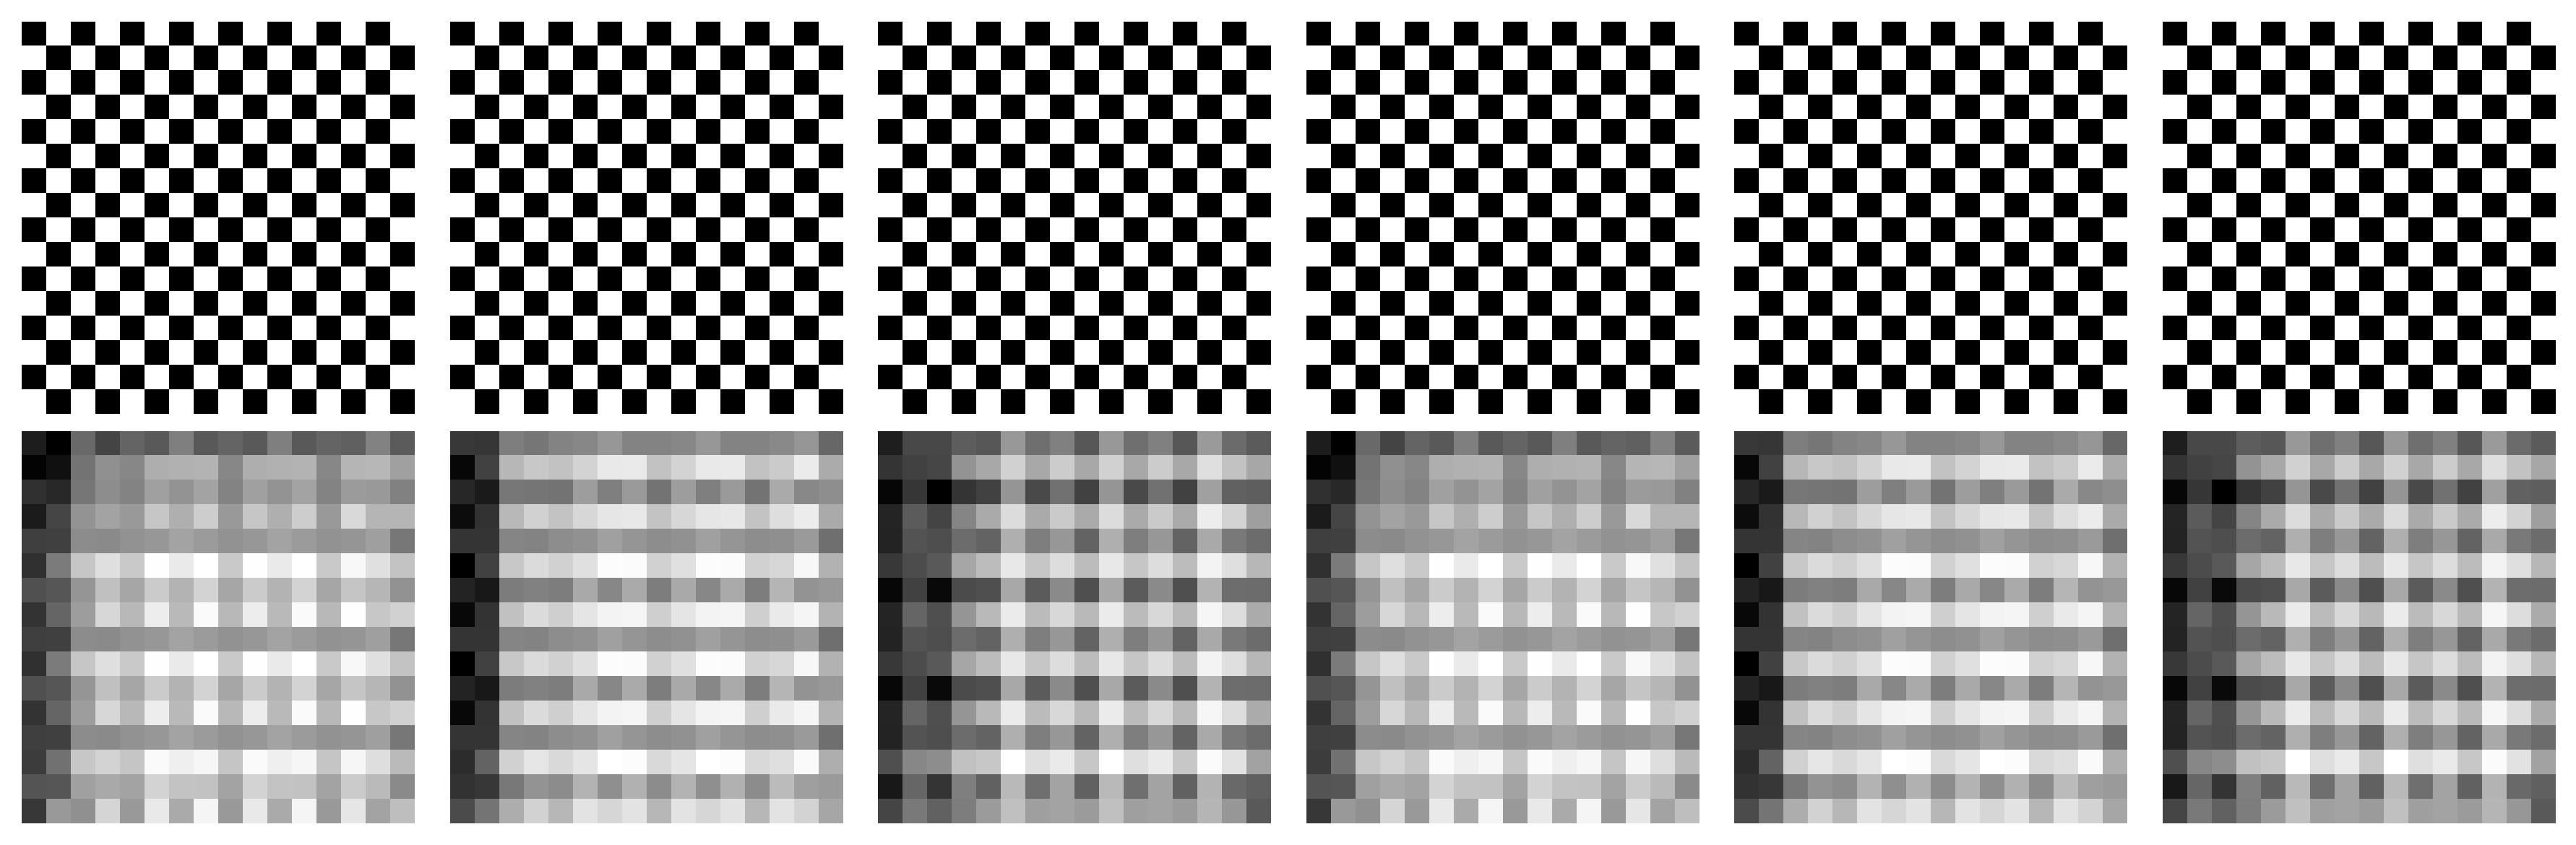

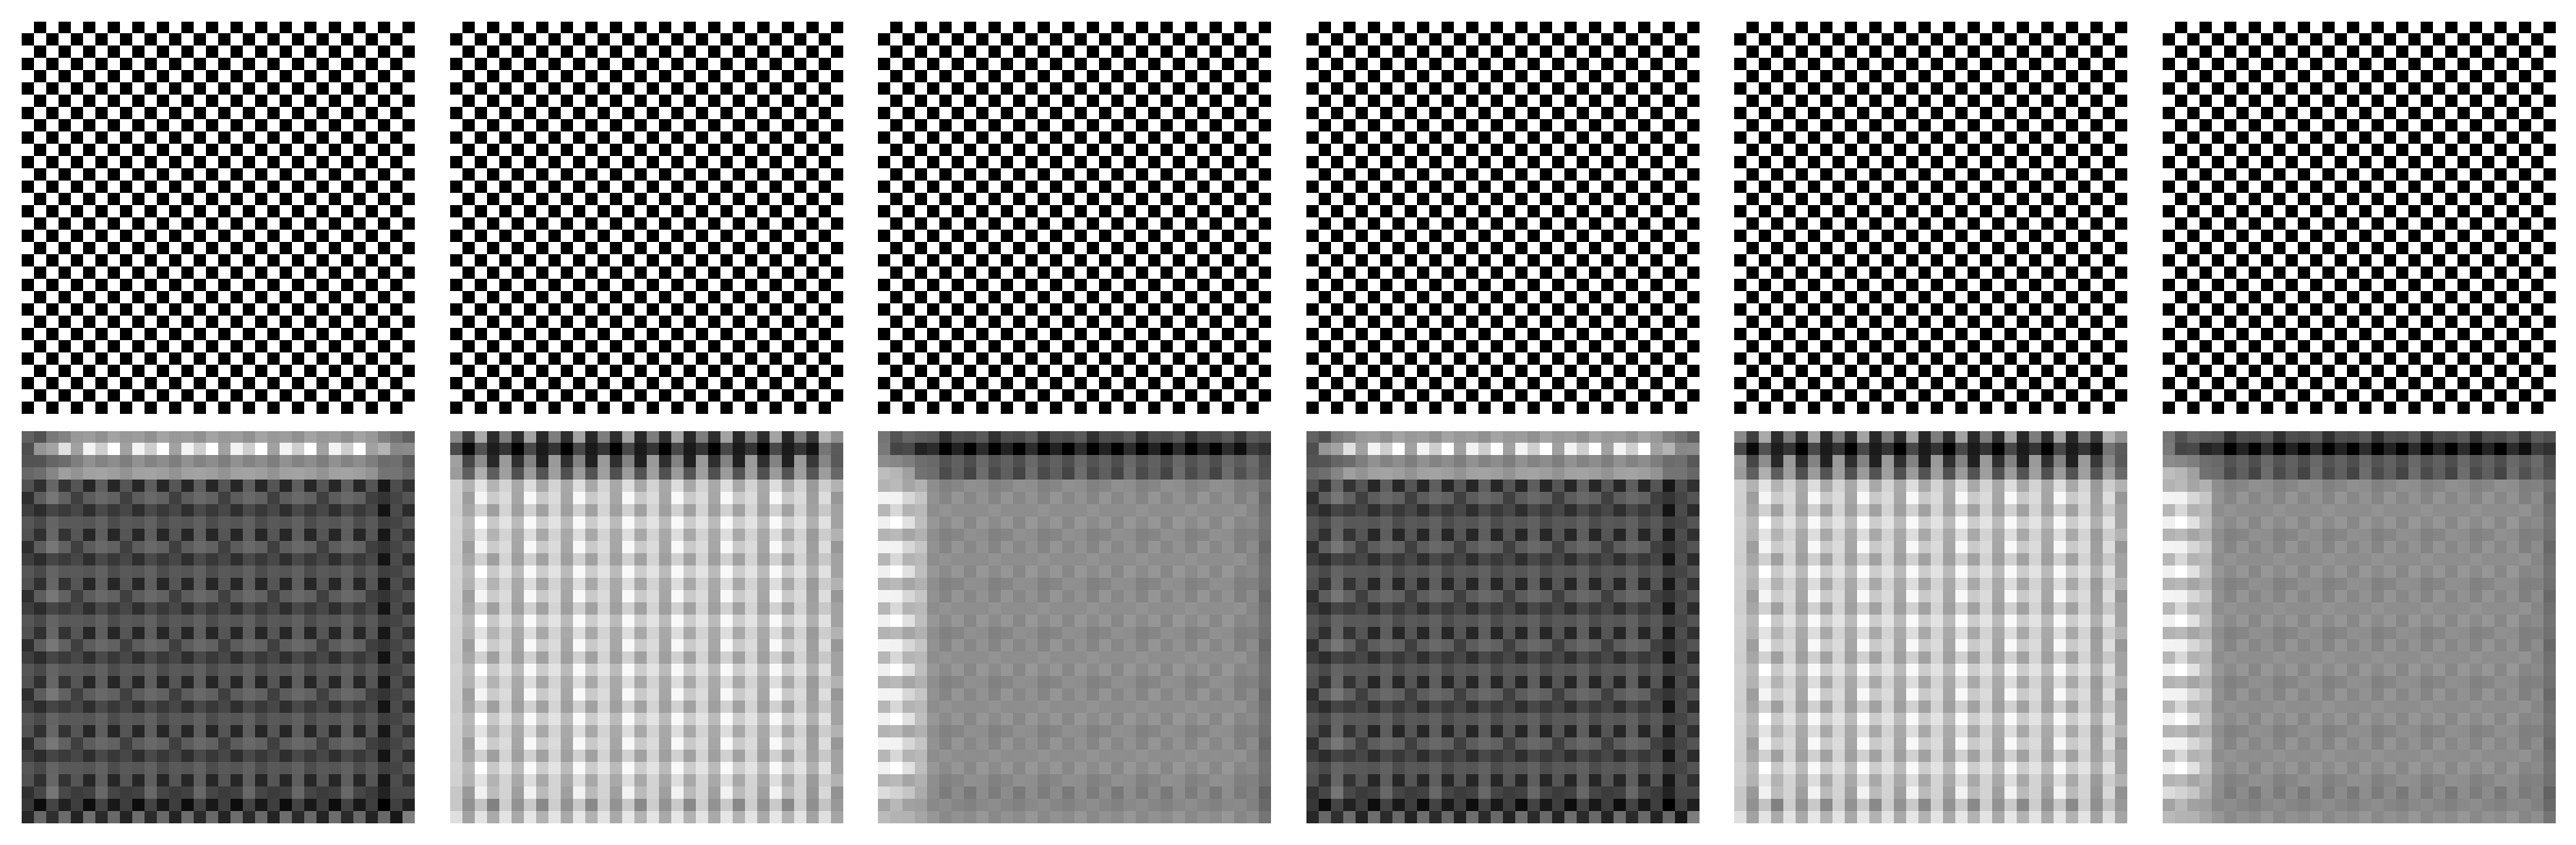

In [14]:
dates = ["2026-02-09_14-09-47", "2026-02-09_14-10-35", "2026-02-09_14-11-26", "2026-02-09_14-12-33"]
# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sideVals = [8, 16, 32, 64]

fullX = np.arange(0.0, 1.1, 0.01)
critX = np.arange(0.15, .4, 0.01)
dataDir = '/home/shashank/Code/gonihedric/data/'
for i in range(3):
    modelSnapshot="/home/shashank/Code/gonihedric/data/checkpoints/Autoencoder/"+dates[i]+"/1/best_model.pth" #0.9
    model.load_state_dict(T.load(modelSnapshot, map_location=device))
    model = model.to(device)

    dataDir = '/home/shashank/Code/gonihedric/bin/isingData/'
    dataset = ds.CustomAutoencoderDataset3D(dataDir+"testL"+str(sideVals[i]), sideVals[i]) #2DGH32
    testLoader = T.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
    visualize_reconstructionG3D(model, device, testLoader, sideVals[i])


In [5]:

from torchinfo import summary
side = 64
summary(model, input_size=(256, 1, side, side, side))

Layer (type:depth-idx)                   Output Shape              Param #
ConvAutoencoder                          [256, 1, 64, 64, 64]      --
├─Sequential: 1-1                        [256, 32, 16, 16, 16]     --
│    └─Conv3d: 2-1                       [256, 16, 32, 32, 32]     448
│    └─BatchNorm3d: 2-2                  [256, 16, 32, 32, 32]     32
│    └─ReLU: 2-3                         [256, 16, 32, 32, 32]     --
│    └─Dropout: 2-4                      [256, 16, 32, 32, 32]     --
│    └─Conv3d: 2-5                       [256, 32, 16, 16, 16]     13,856
│    └─BatchNorm3d: 2-6                  [256, 32, 16, 16, 16]     64
│    └─ReLU: 2-7                         [256, 32, 16, 16, 16]     --
├─Sequential: 1-2                        [256, 1, 64, 64, 64]      --
│    └─Dropout: 2-8                      [256, 32, 16, 16, 16]     --
│    └─ConvTranspose3d: 2-9              [256, 16, 32, 32, 32]     13,840
│    └─BatchNorm3d: 2-10                 [256, 16, 32, 32, 32]     32
│    └

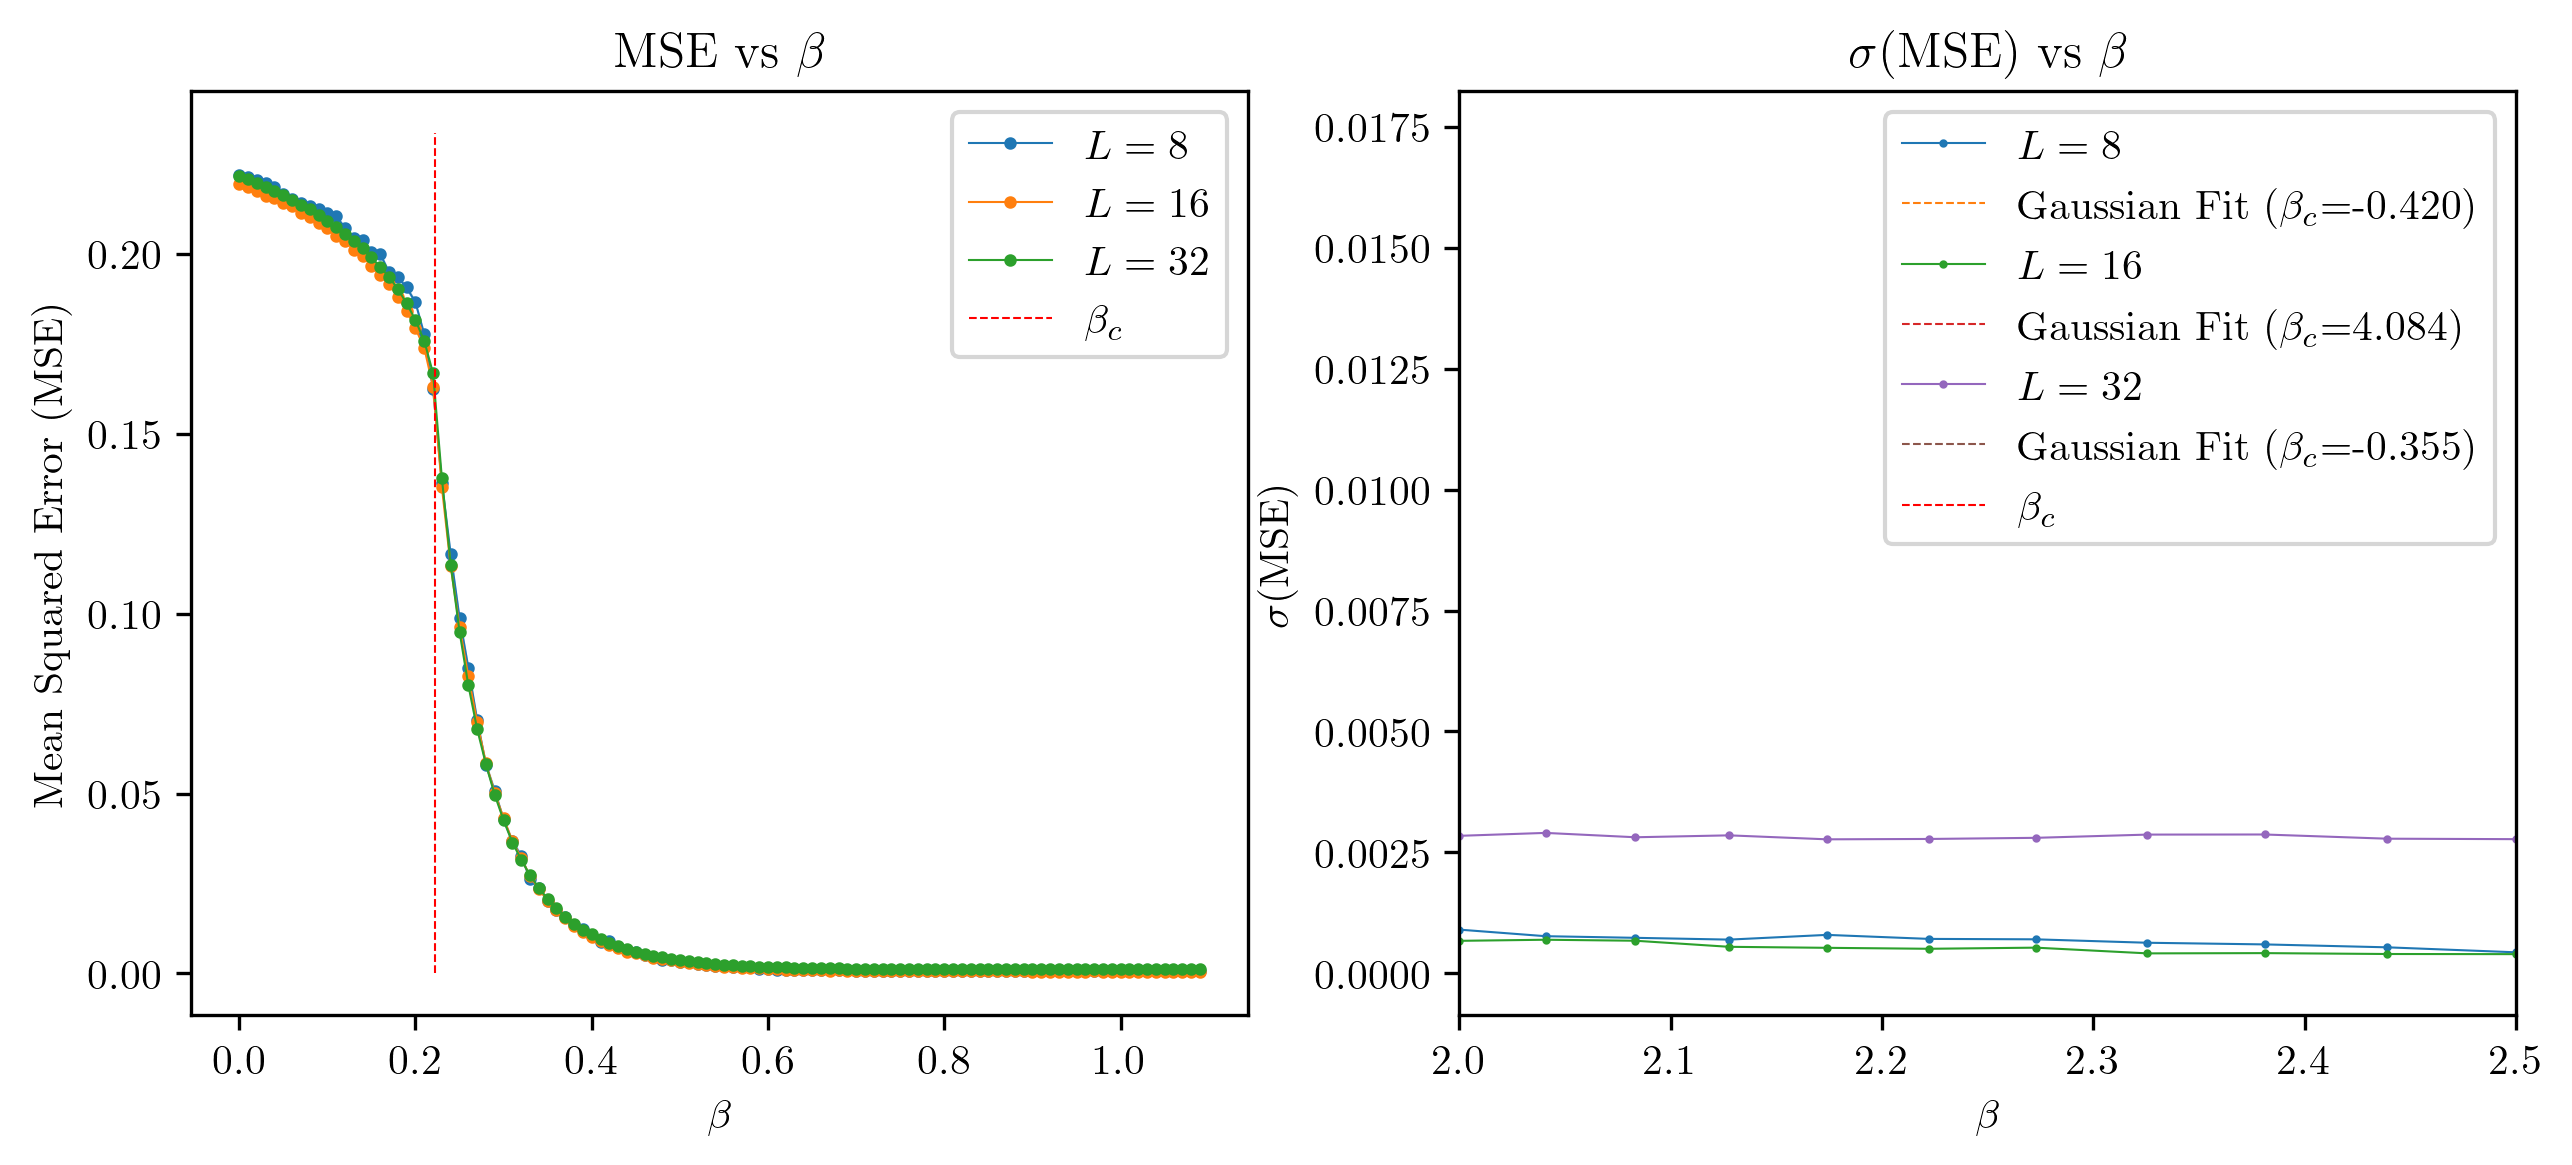

In [ ]:
dates = ["2026-02-06_18-14-24", "2026-02-06_18-15-22", "2026-02-06_18-16-37"]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
sideVals = [8, 16, 32]

fullX = np.arange(0.0, 1.1, 0.01)
critX = np.arange(0.15, .4, 0.01)
dataDir = '/home/shashank/Code/gonihedric/data/'
for i in range(3):
    modelSnapshot="/home/shashank/Code/gonihedric/data/checkpoints/Autoencoder/"+dates[i]+"/1/best_model.pth" #0.9
    model.load_state_dict(T.load(modelSnapshot, map_location=device))
    model = model.to(device)

    testLossesMean = np.empty(len(fullX))
    testLossesStd = np.empty(len(fullX))
    batchSize = 1000
    # dataset = ds.CustomAutoencoderDataset3D(dataDir+"testL10k"+"{:.1f}".format(k), side) #2DGH32
    side = sideVals[i]
    dataset = ds.CustomAutoencoderDataset3D(dataDir+"testL"+str(side), side) #2DGH32
    testLoader = T.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=False)
    model.eval()
    tmpCount = np.zeros(len(fullX), dtype=int); tmpLosses = np.empty([len(fullX), 100])
    with T.no_grad():
        for batch_idx, (images,label) in enumerate(testLoader):
            images = images.to(device)
            label = label.numpy()
            outputs = model(images)
            loss = F.mse_loss(outputs, images, reduction='none').mean((2,3,4)).squeeze().cpu().numpy()
            for i in range(len(loss)):
                tmpLosses[np.round(label[i]*100).astype(int), tmpCount[np.round(label[i]*100).astype(int)]] = loss[i]
                tmpCount[np.round(label[i]*100).astype(int)] += 1
    testLossesMean = np.mean(tmpLosses, axis=1)
    testLossesStd = np.std(tmpLosses, axis=1)/np.sqrt(tmpCount)

    ax[0].plot(fullX, testLossesMean[:], linewidth=0.5, marker='o', markersize=2, label=r'$L='+str(side)+'$')
    ax[0].fill_between(fullX, 
                    testLossesMean[:]-testLossesStd[:],
                    testLossesMean[:]+testLossesStd[:], alpha=0.2)
    ax[1].plot(1/fullX[1:], np.flip(testLossesStd[1:]*side), linewidth=0.5, marker='.', markersize=2, label=r'$L='+str(side)+'$')
    popt, pcov = curve_fit(lambda x, a, c: a*np.exp(-(x-c)*(x-c)), critX, testLossesStd[15:40]*side, p0=[1, 1], maxfev=10000)
    critX = 1/critX
    ax[1].plot(critX, popt[0]*np.exp(-(critX-popt[1])*(critX-popt[1])) , label=r'Gaussian Fit ($\beta_c$={:.3f})'.format(popt[1]), linestyle='dashed', linewidth=0.5)

ax[0].vlines(0.2216, 0, ax[0].get_ylim()[1], colors='r', linestyles='dashed', label=r'$\beta_c$', linewidth=0.5)
ax[1].vlines(0.2216, 0, ax[1].get_ylim()[1], colors='r', linestyles='dashed', label=r'$\beta_c$', linewidth=0.5)
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel(r'$\sigma$(MSE)')
ax[1].set_title(r'$\sigma$(MSE) vs $\beta$')
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Mean Squared Error (MSE)')
ax[0].set_title(r'MSE vs $\beta$')
ax[0].legend()
ax[1].legend()
# ax[1].set_xlim(2, 2.5)
plt.show()


In [36]:
# np.mean(tmpLosses, axis=1).shape
len(fullX)

110

In [50]:
dates = ["2026-02-06_18-14-24", "2026-02-06_18-15-22", "2026-02-06_18-16-37"]

sideVals = [8, 16, 32]
N =3
testLossesMean = np.empty((len(fullX), N))
testLossesStd = np.empty((len(fullX), N))

dataDir = '/home/shashank/Code/gonihedric/data/'
for i in range(N):
    modelSnapshot="/home/shashank/Code/gonihedric/data/checkpoints/Autoencoder/"+dates[0]+"/1/best_model.pth" #0.9
    model.load_state_dict(T.load(modelSnapshot, map_location=device))
    model = model.to(device)
    fullX = np.arange(0.0, 1.1, 0.01)
    critX = np.arange(0.15, .4, 0.01)
    batchSize = 1000
    # dataset = ds.CustomAutoencoderDataset3D(dataDir+"testL10k"+"{:.1f}".format(k), side) #2DGH32
    side = sideVals[i]
    dataset = ds.CustomAutoencoderDataset3D(dataDir+"testL"+str(side), side) #2DGH32
    testLoader = T.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=False)
    model.eval()
    tmpCount = np.zeros(len(fullX), dtype=int); tmpLosses = np.empty([len(fullX), 100])
    with T.no_grad():
        for batch_idx, (images,label) in enumerate(testLoader):
            images = images.to(device)
            label = label.numpy()
            outputs = model(images)
            loss = F.mse_loss(outputs, images, reduction='none').mean((2,3,4)).squeeze().cpu().numpy()
            for j in range(len(loss)):
                tmpLosses[np.round(label[j]*100).astype(int), tmpCount[np.round(label[j]*100).astype(int)]] = loss[j]
                tmpCount[np.round(label[j]*100).astype(int)] += 1
    testLossesMean[:, i] = np.mean(tmpLosses, axis=1)
    testLossesStd[:, i] = np.std(tmpLosses, axis=1)/np.sqrt(tmpCount)

In [60]:
(1/0.2216)*(1/4)

1.128158844765343

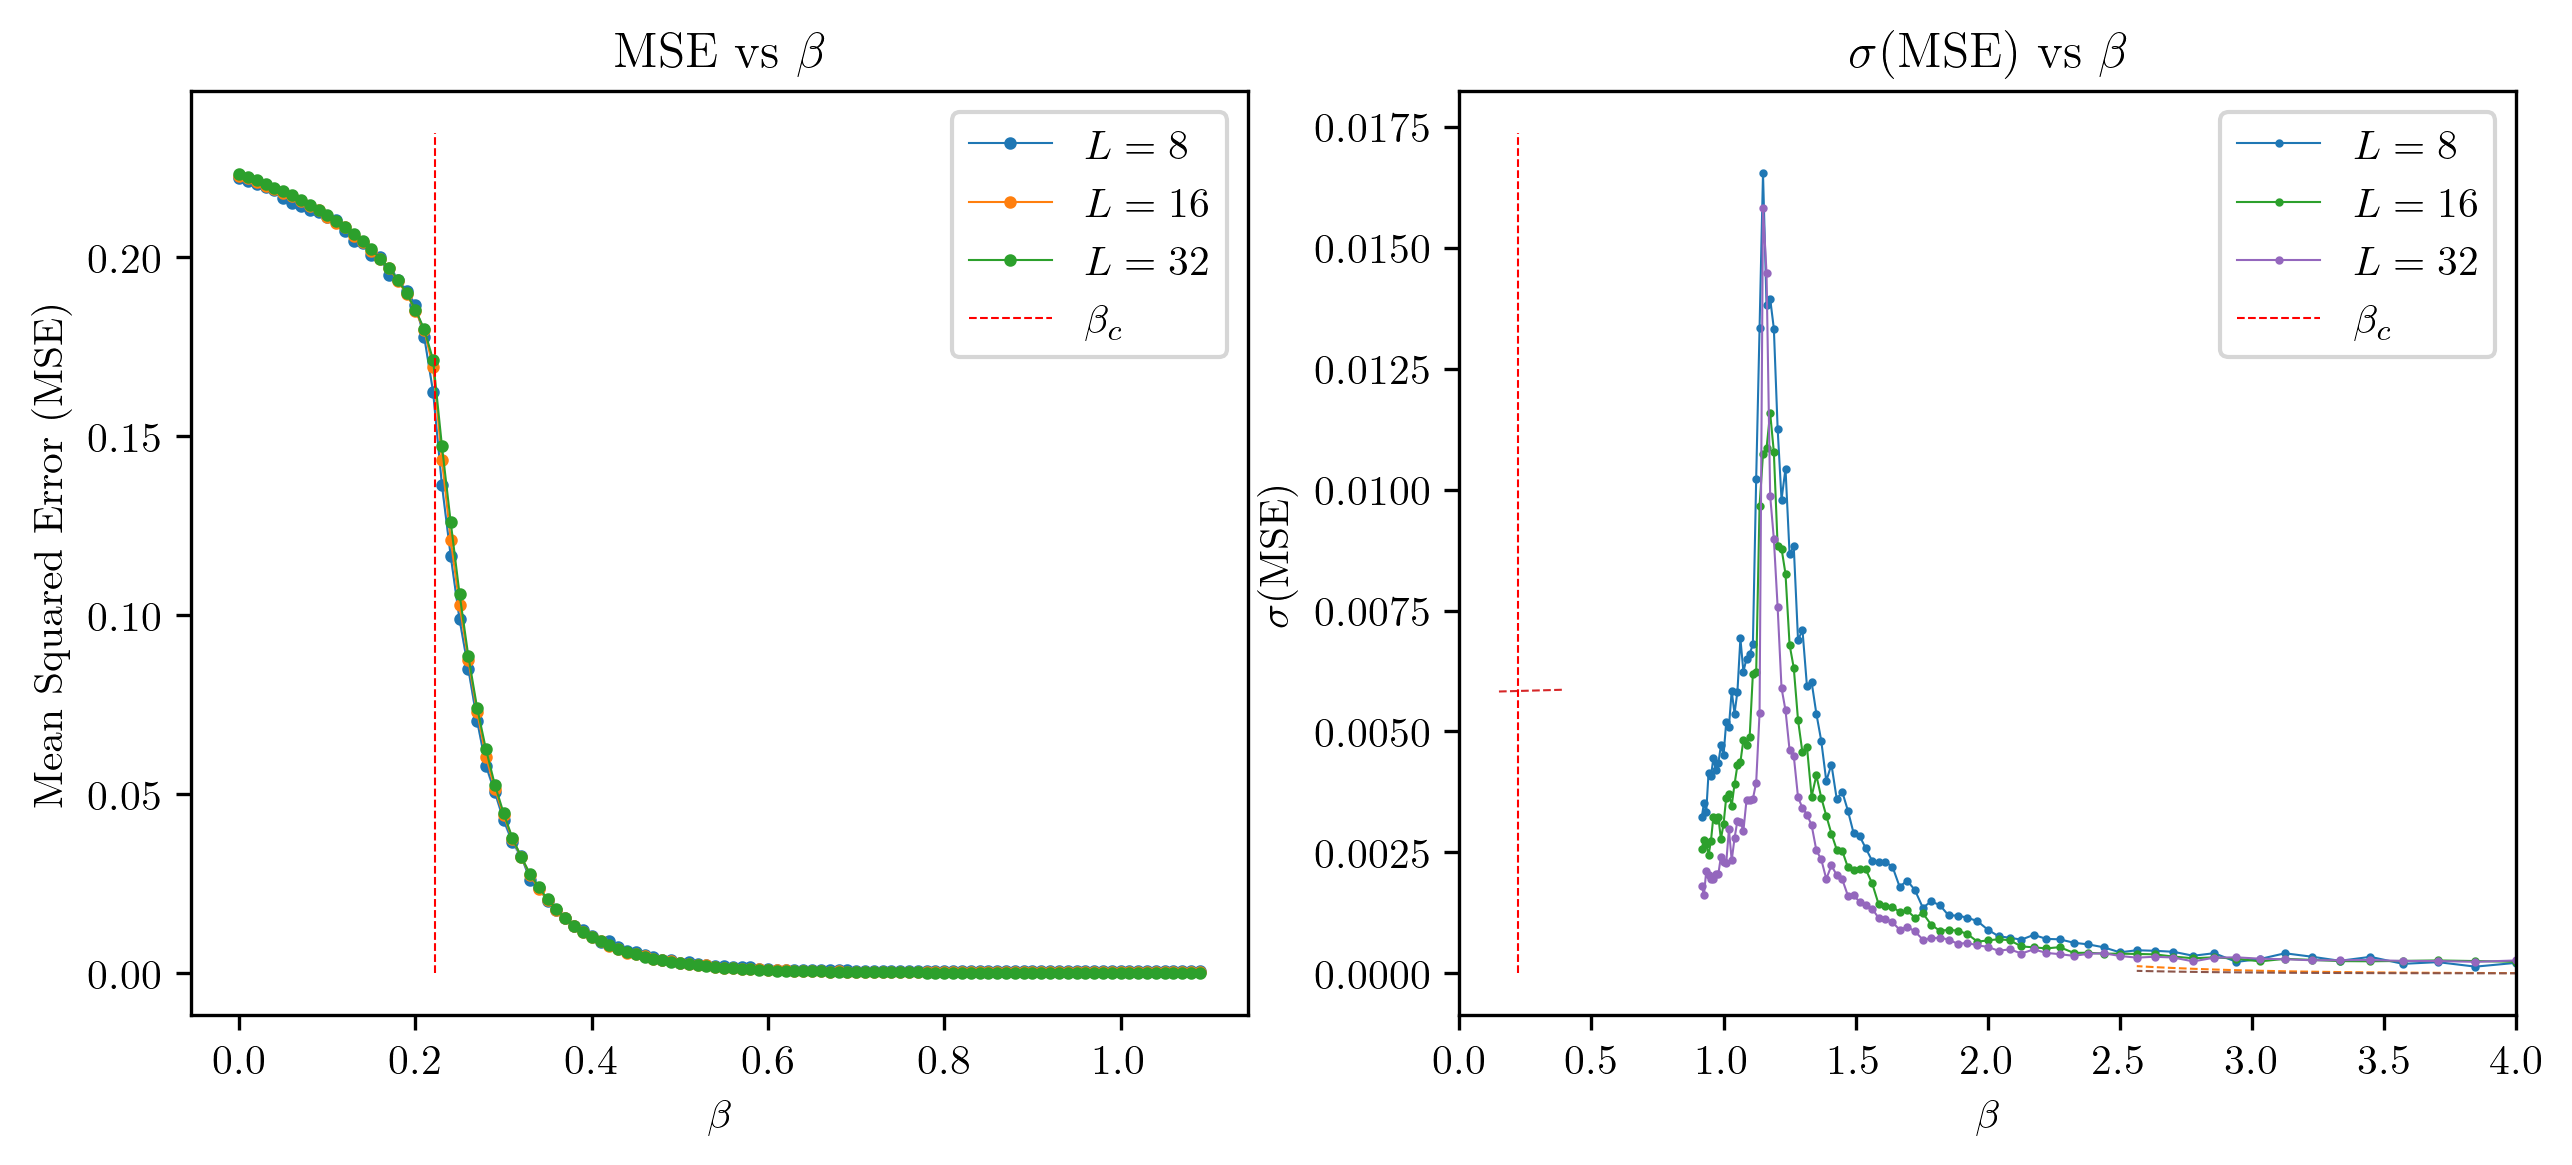

In [77]:

N =3

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for i in range(N):
    fullX = np.arange(0.0, 1.1, 0.01)
    ax[0].plot(fullX, testLossesMean[:, i], linewidth=0.5, marker='o', markersize=2, label=r'$L='+str(sideVals[i])+'$')
    ax[0].fill_between(fullX, 
                    testLossesMean[:, i]-testLossesStd[:, i],
                    testLossesMean[:, i]+testLossesStd[:, i], alpha=0.2)
    
    popt, pcov = curve_fit(lambda x, s, m: 1/(s*np.sqrt(2*np.pi))*np.exp(-(x-m)*(x-m)/(2*s*s)), critX, testLossesStd[15:40, i]*sideVals[i], p0=[1, 1], maxfev=10000)
    stdTmp = np.flip(testLossesStd[1:, i]); fullX = 1/fullX[1:]
    ax[1].plot(fullX, stdTmp*sideVals[i], linewidth=0.5, marker='.', markersize=2, label=r'$L='+str(sideVals[i])+'$')

    critX = 1/critX
    # ax[1].plot(fullX, testLossesStd[:, i]*sideVals[i], linewidth=0.5, marker='.', markersize=2, label=r'$L='+str(sideVals[i])+'$')
    ax[1].plot(critX, 1/(popt[0]*np.sqrt(2*np.pi))*np.exp(-(critX-popt[1])*(critX-popt[1])/(2*popt[0]*popt[0])), linestyle='dashed', linewidth=0.5)

ax[0].vlines(0.2216, 0, ax[0].get_ylim()[1], colors='r', linestyles='dashed', label=r'$\beta_c$', linewidth=0.5)
ax[1].vlines(0.2216, 0, ax[1].get_ylim()[1], colors='r', linestyles='dashed', label=r'$\beta_c$', linewidth=0.5)
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel(r'$\sigma$(MSE)')
ax[1].set_title(r'$\sigma$(MSE) vs $\beta$')
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Mean Squared Error (MSE)')
ax[0].set_title(r'MSE vs $\beta$')
ax[0].legend()
ax[1].legend()
# ax[1].set_xlim(0.15, 0.4)
ax[1].set_xlim(0, 4)
plt.show()


In [ ]:
# modelSnapshot = "/home/shashank/Code/gonihedric/data/ghData/checkpoints/Autoencoder/2026-01-27_18-09-53/1/best_model.pth"
# modelSnapshot = "/home/shashank/Code/gonihedric/data/ghData/checkpoints/Autoencoder/2026-01-27_18-51-25/1/best_model.pth"
# modelSnapshot="/home/shashank/Code/gonihedric/data/ghData/checkpoints/Autoencoder/2026-01-28_10-36-45/1/best_model.pth" #Ising
modelSnapshot="/home/shashank/Code/gonihedric/data/ghData/checkpoints/Autoencoder/2026-02-04_10-51-08/1/best_model.pth" #0.1
# modelSnapshot="/home/shashank/Code/gonihedric/data/ghData/checkpoints/Autoencoder/2026-02-04_10-47-02/1/best_model.pth" #0.9
model.load_state_dict(T.load(modelSnapshot, map_location=device))
model = model.to(device)
model.eval()

temperatures = np.arange(0.0, 1.1, 0.01)
testLossesMean = np.empty(len(temperatures))
testLossesStd = np.empty(len(temperatures))
batchSize = 1000
k = 0.1
# dataset = ds.CustomAutoencoderDataset3D(dataDir+"testL10k"+"{:.1f}".format(k), side) #2DGH32

dataset = ds.CustomAutoencoderDataset3D(dataDir+"testL10k0.1", side) #2DGH32
testLoader = T.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=False)
model.eval()
j = 0
tmpCount = np.zeros(len(temperatures), dtype=int); tmpLosses = np.empty([len(temperatures), 1000])
with T.no_grad():
    for batch_idx, (images,label) in enumerate(testLoader):
        images = images.to(device)
        label = label.numpy()
        outputs = model(images)
        loss = F.mse_loss(outputs, images, reduction='none').mean((2,3,4)).squeeze().cpu().numpy()
        for i in range(len(loss)):
            tmpLosses[np.round(label[i]*100).astype(int), tmpCount[np.round(label[i]*100).astype(int)]] = loss[i]
            tmpCount[np.round(label[i]*100).astype(int)] += 1
testLossesMean = np.mean(tmpLosses, axis=1)
testLossesStd = np.std(tmpLosses, axis=1)/np.sqrt(tmpCount)


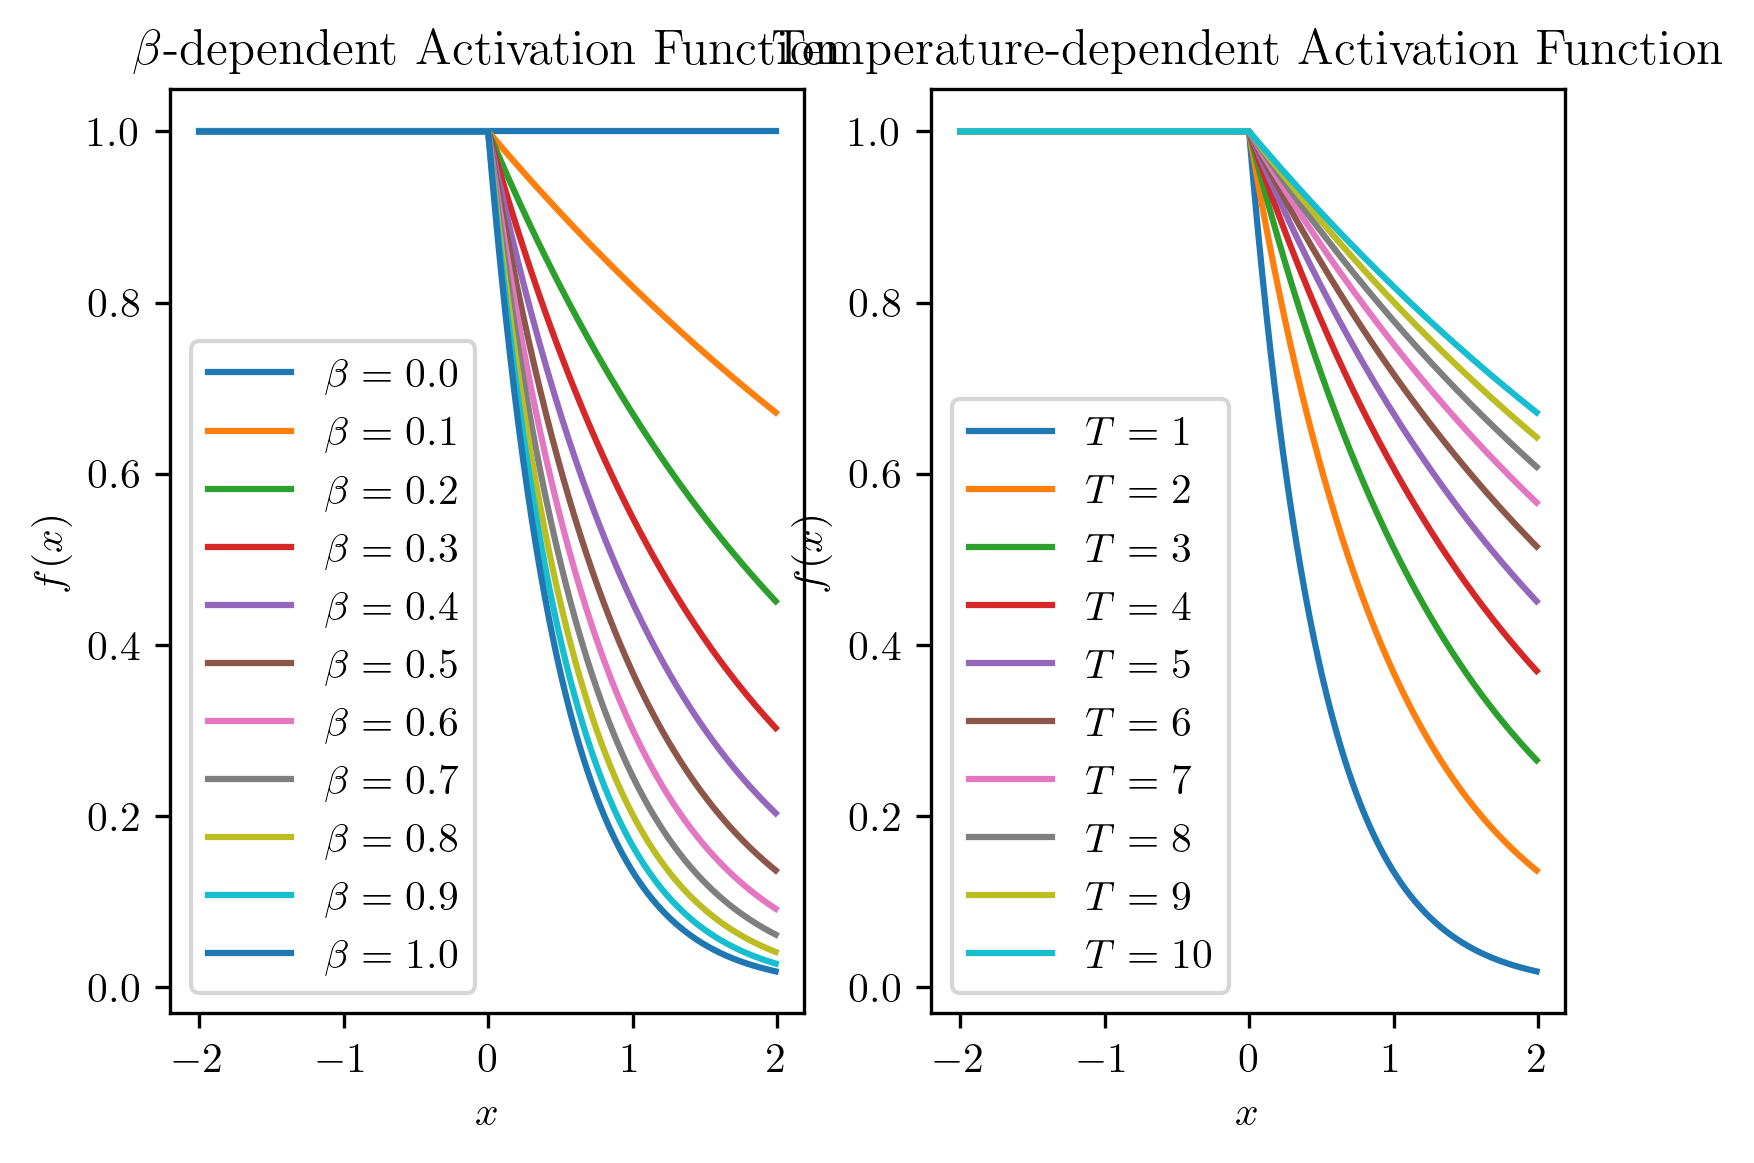

In [74]:
betaVals = np.arange(0.0, 1.1, 0.1)
tempVals = np.arange(1, 11, 1)
x = np.arange(-2, 2, 0.01)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 4))
def f(x, beta):
    return np.minimum(1, np.exp(-2*beta*x))
for beta in betaVals:
    ax[0].plot(x, f(x, beta), label=r'$\beta={:.1f}$'.format(beta))
for temp in tempVals:
    ax[1].plot(x, f(x, 1/temp), label=r'$T={:.0f}$'.format(temp))
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$f(x)$')
ax[0].set_title(r'$\beta$-dependent Activation Function')
ax[0].legend()
ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$f(x)$')
ax[1].set_title(r'Temperature-dependent Activation Function')
ax[1].legend()

plt.show()

In [8]:
# modelSnapshot="/home/shashank/Code/gonihedric/data/ghData/checkpoints/Autoencoder/2026-02-03_17-35-40/1/best_model.pth" #0.9
modelSnapshot="/home/shashank/Code/gonihedric/data/ghData/checkpoints/Autoencoder/2026-02-03_18-03-04/1/best_model.pth" #0.9
modelSnapshot="/home/shashank/Code/gonihedric/data/ghData/checkpoints/Autoencoder/2026-02-04_10-40-56/1/best_model.pth" #0.9
model.load_state_dict(T.load(modelSnapshot, map_location=device))
model = model.to(device)
model.eval()

temperatures = np.arange(0.0, 1.1, 0.01)
testLossesMean = np.empty(len(temperatures))
testLossesStd = np.empty(len(temperatures))
batchSize = 1000
k = 0.0
# dataset = ds.CustomAutoencoderDataset3D(dataDir+"testL10k"+"{:.1f}".format(k), side) #2DGH32

dataset = ds.CustomAutoencoderDataset3D(dataDir+"testL10k0.0", side) #2DGH32
testLoader = T.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=False)
model.eval()
j = 0
tmpCount = np.zeros(len(temperatures), dtype=int); tmpLosses = np.empty([len(temperatures), 1000])
with T.no_grad():
    for batch_idx, (images,label) in enumerate(testLoader):
        images = images.to(device)
        label = label.numpy()
        outputs = model(images)
        loss = F.mse_loss(outputs, images, reduction='none').mean((2,3,4)).squeeze().cpu().numpy()
        for i in range(len(loss)):
            tmpLosses[np.round(label[i]*100).astype(int), tmpCount[np.round(label[i]*100).astype(int)]] = loss[i]
            tmpCount[np.round(label[i]*100).astype(int)] += 1
testLossesMean = np.mean(tmpLosses, axis=1)
testLossesStd = np.std(tmpLosses, axis=1)/np.sqrt(tmpCount)


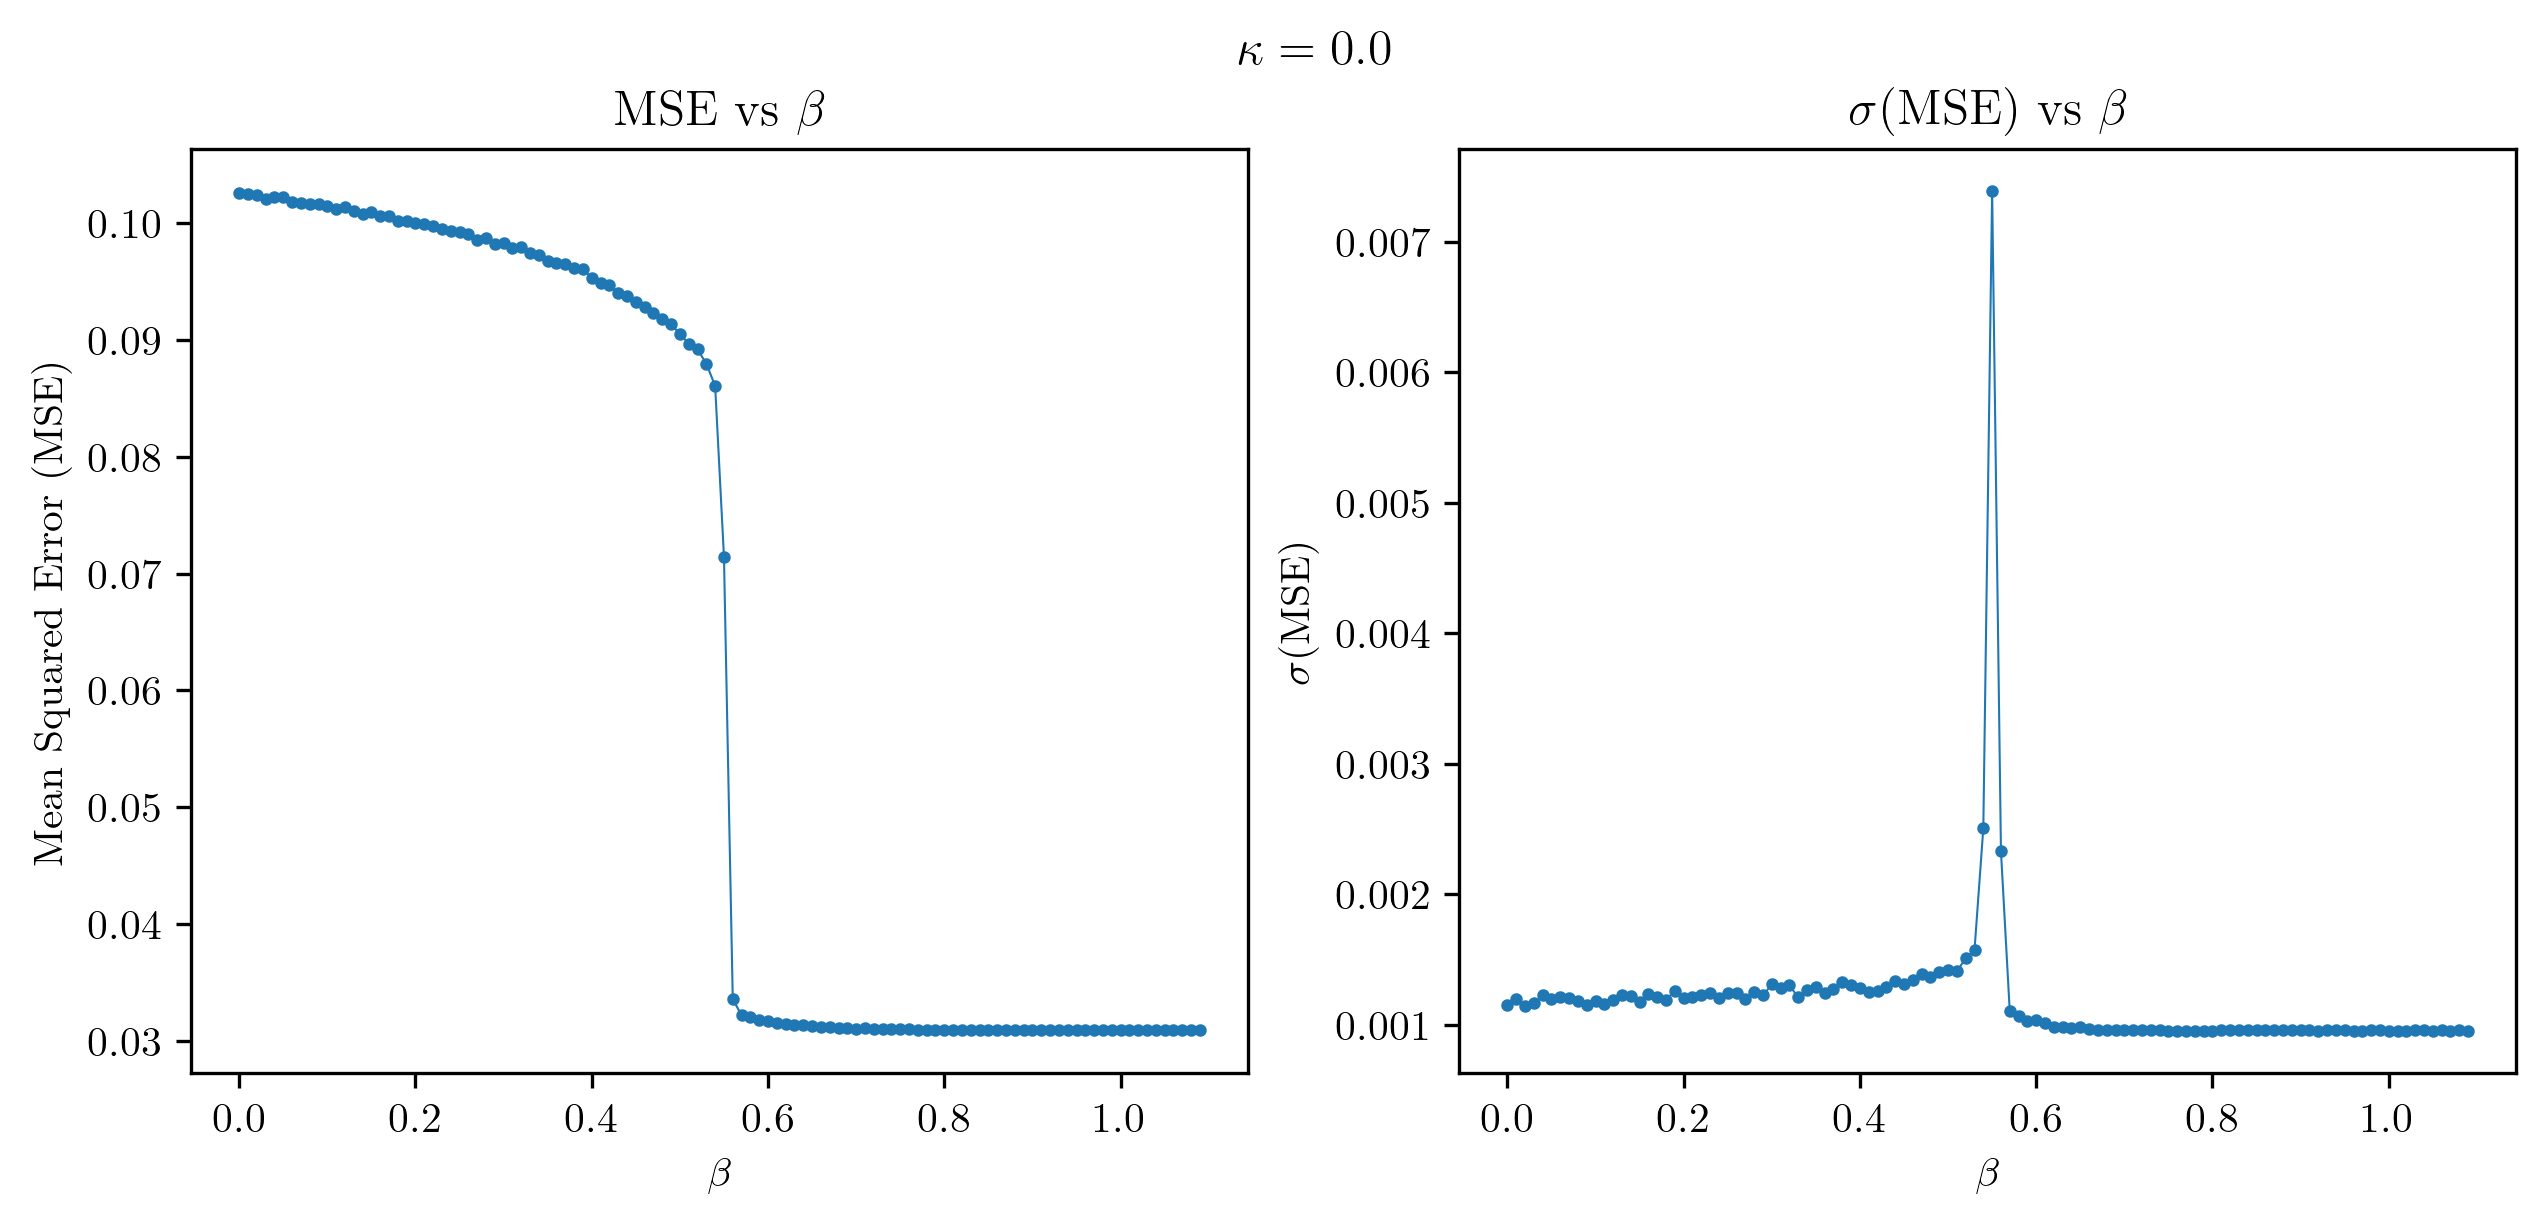

In [9]:

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(np.arange(0.0, 1.1, 0.01), testLossesMean[:], linewidth=0.5, marker='o', markersize=2)
ax[0].fill_between(np.arange(0.0, 1.1, 0.01), 
                 testLossesMean[:]-testLossesStd[:],
                 testLossesMean[:]+testLossesStd[:], alpha=0.2)
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Mean Squared Error (MSE)')
ax[0].set_title(r'MSE vs $\beta$')

ax[1].plot(np.arange(0.0, 1.1, 0.01), testLossesStd[:]*10, linewidth=0.5, marker='o', markersize=2)
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel(r'$\sigma$(MSE)')
ax[1].set_title(r'$\sigma$(MSE) vs $\beta$')


fig.suptitle(r'$\kappa={}$'.format(k))

plt.show()

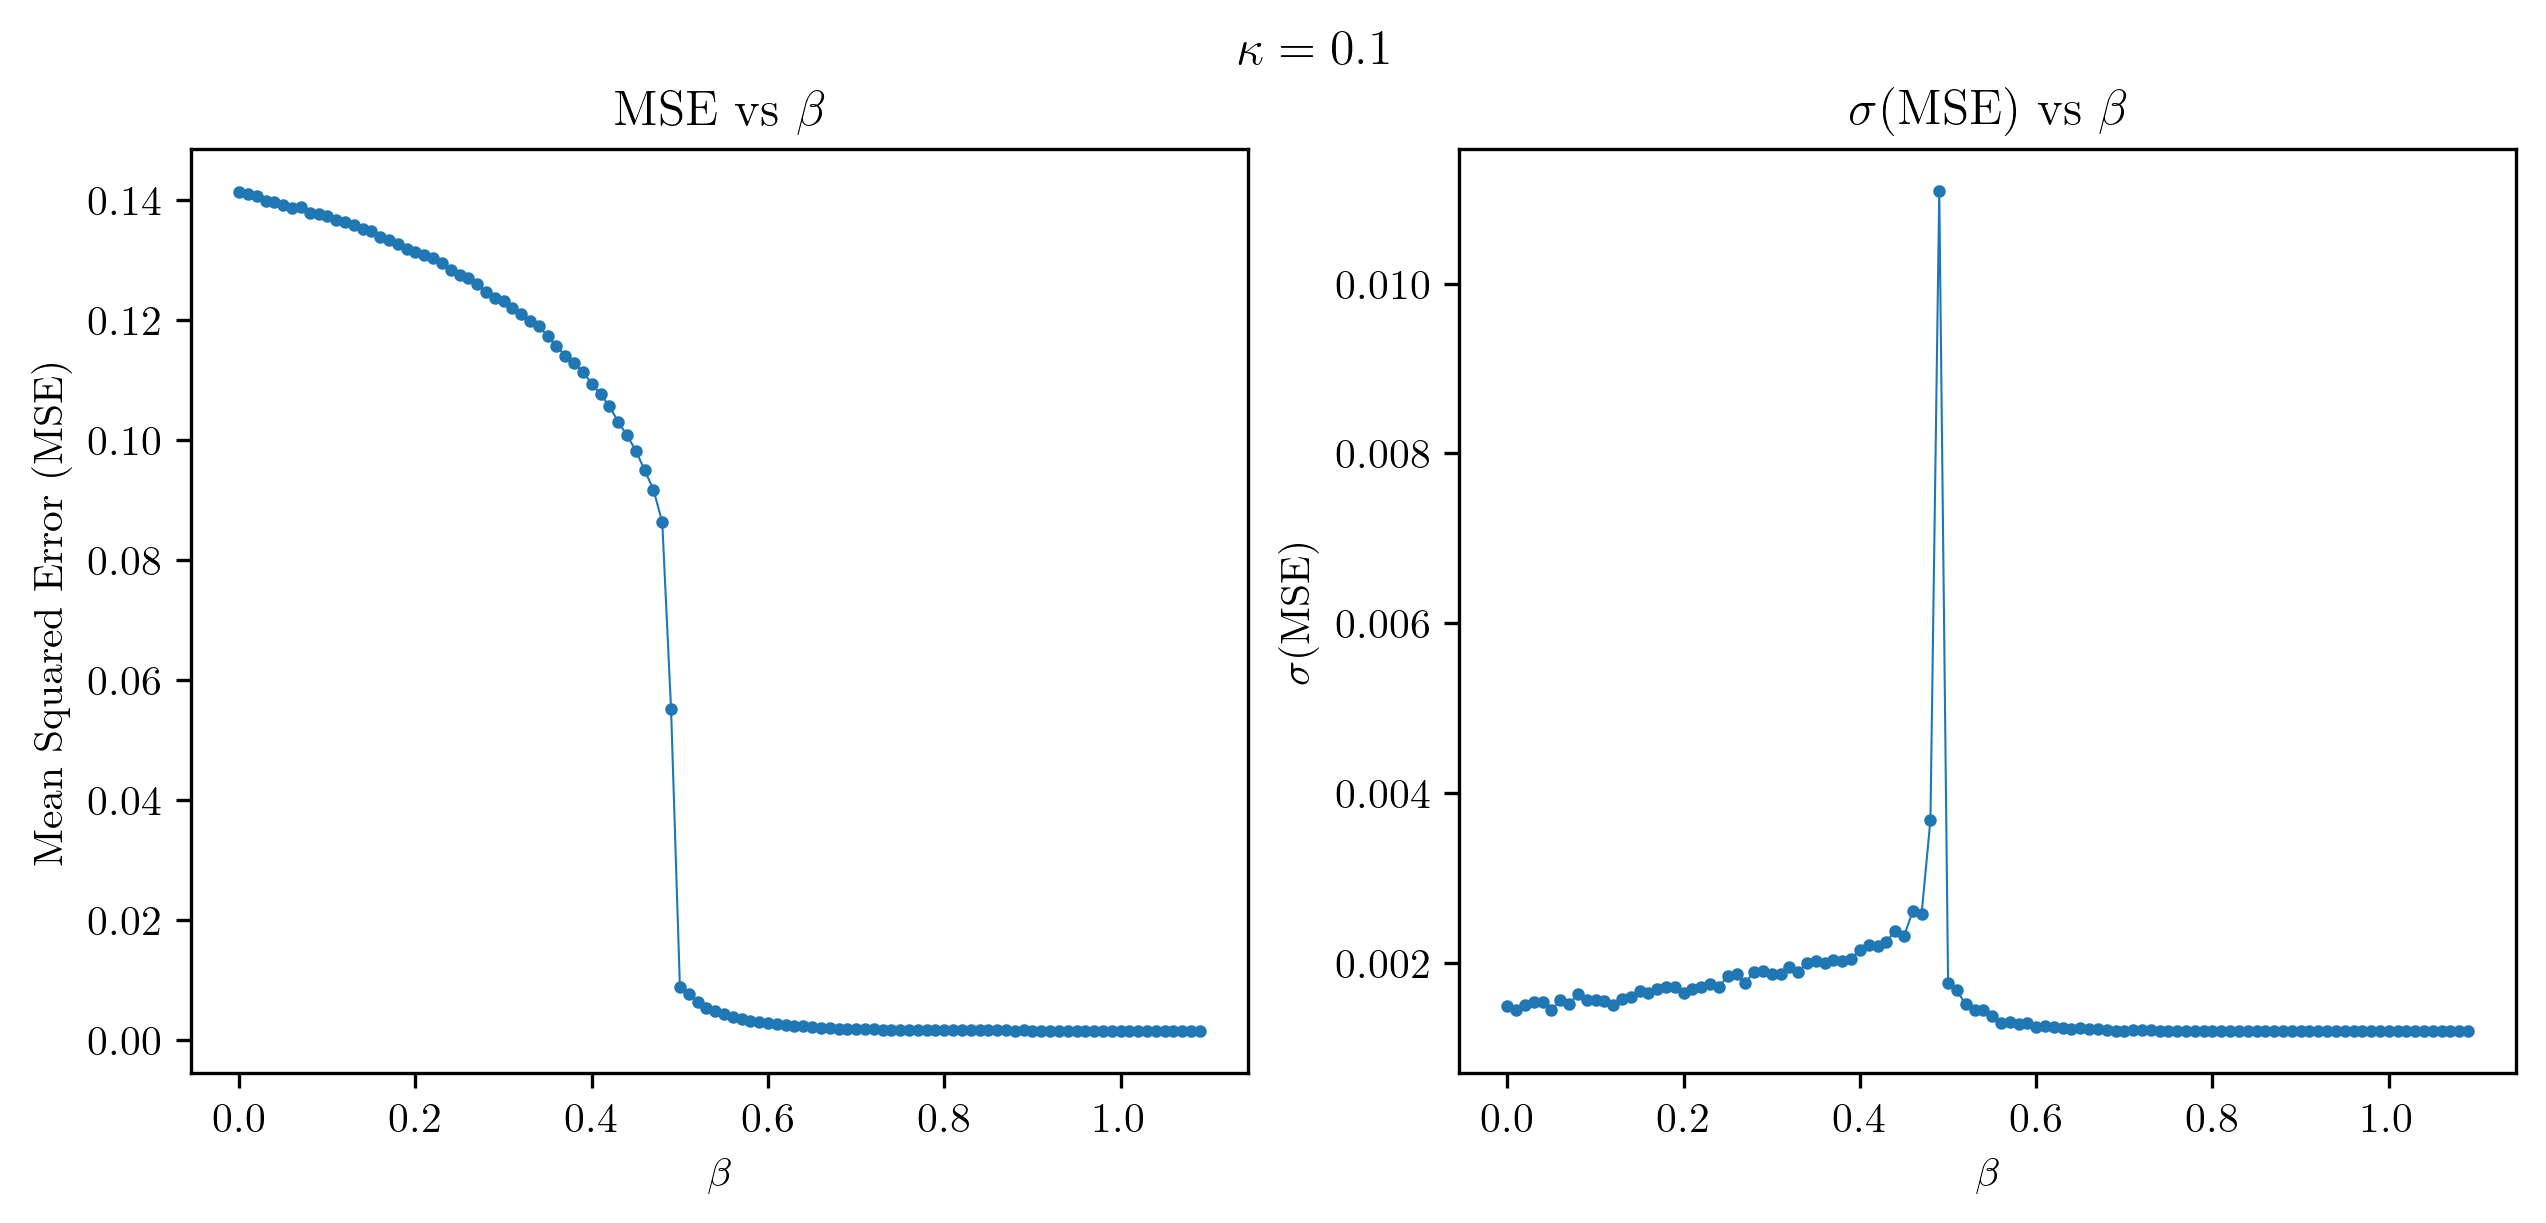

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(np.arange(0.0, 1.1, 0.01), testLossesMean[:], linewidth=0.5, marker='o', markersize=2)
ax[0].fill_between(np.arange(0.0, 1.1, 0.01), 
                 testLossesMean[:]-testLossesStd[:],
                 testLossesMean[:]+testLossesStd[:], alpha=0.2)
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Mean Squared Error (MSE)')
ax[0].set_title(r'MSE vs $\beta$')

ax[1].plot(np.arange(0.0, 1.1, 0.01), testLossesStd[:]*10, linewidth=0.5, marker='o', markersize=2)
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel(r'$\sigma$(MSE)')
ax[1].set_title(r'$\sigma$(MSE) vs $\beta$')


fig.suptitle(r'$\kappa={}$'.format(k))

plt.show()

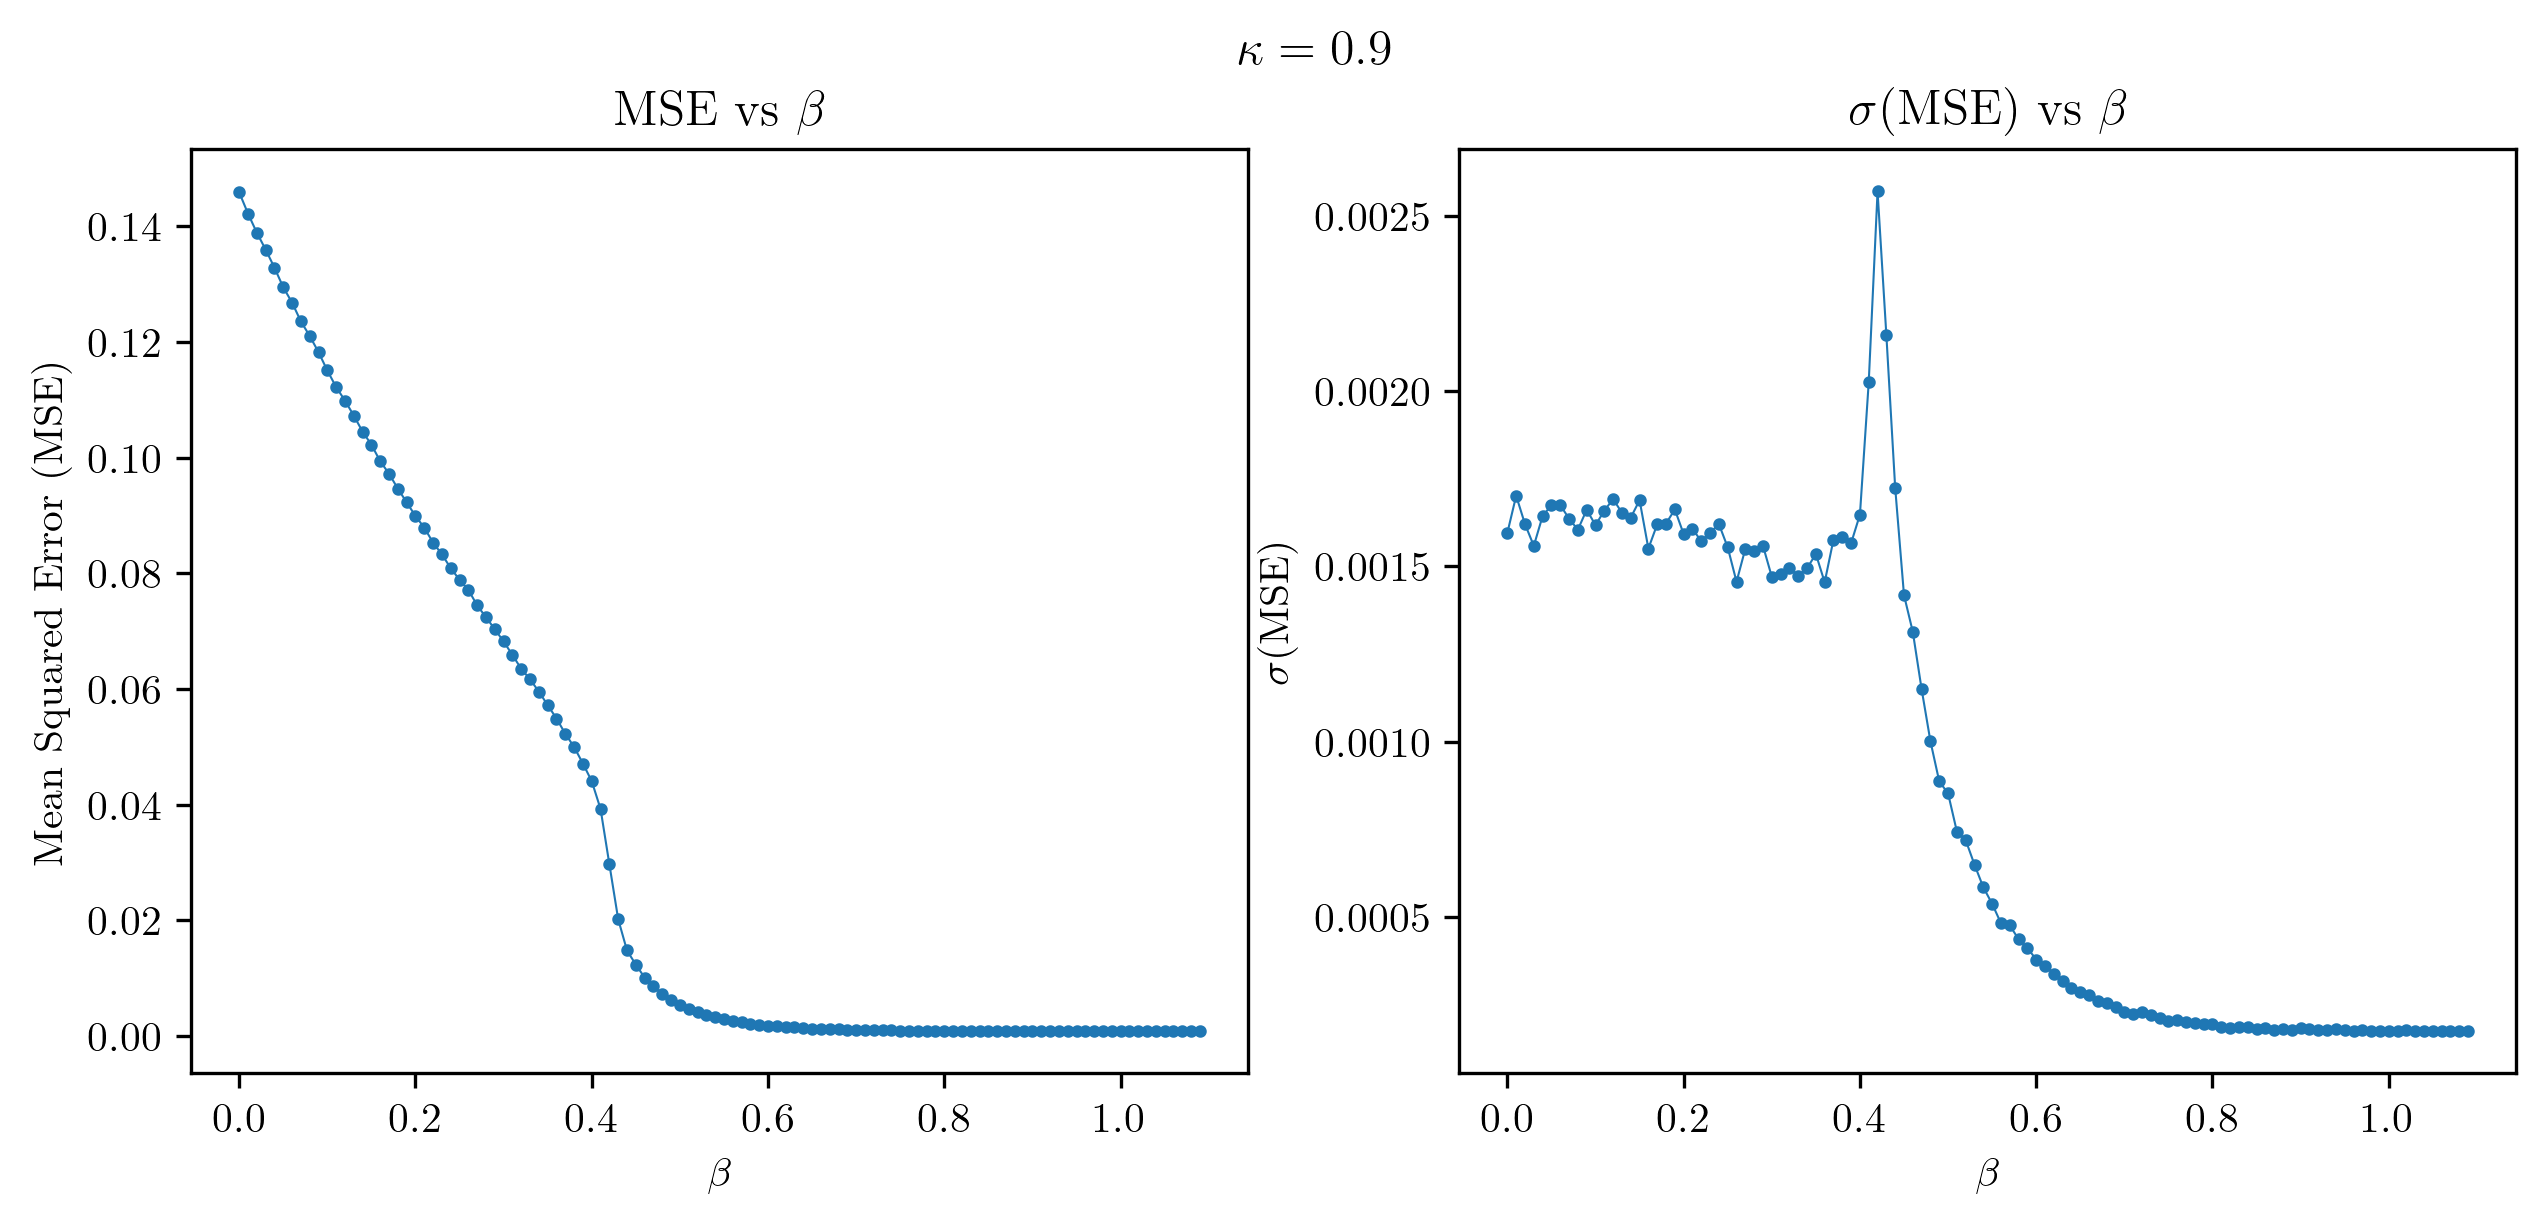

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(np.arange(0.0, 1.1, 0.01), testLossesMean[:], linewidth=0.5, marker='o', markersize=2)
ax[0].fill_between(np.arange(0.0, 1.1, 0.01), 
                 testLossesMean[:]-testLossesStd[:],
                 testLossesMean[:]+testLossesStd[:], alpha=0.2)
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Mean Squared Error (MSE)')
ax[0].set_title(r'MSE vs $\beta$')

ax[1].plot(np.arange(0.0, 1.1, 0.01), testLossesStd[:]*10, linewidth=0.5, marker='o', markersize=2)
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel(r'$\sigma$(MSE)')
ax[1].set_title(r'$\sigma$(MSE) vs $\beta$')


fig.suptitle(r'$\kappa={}$'.format(k))

plt.show()

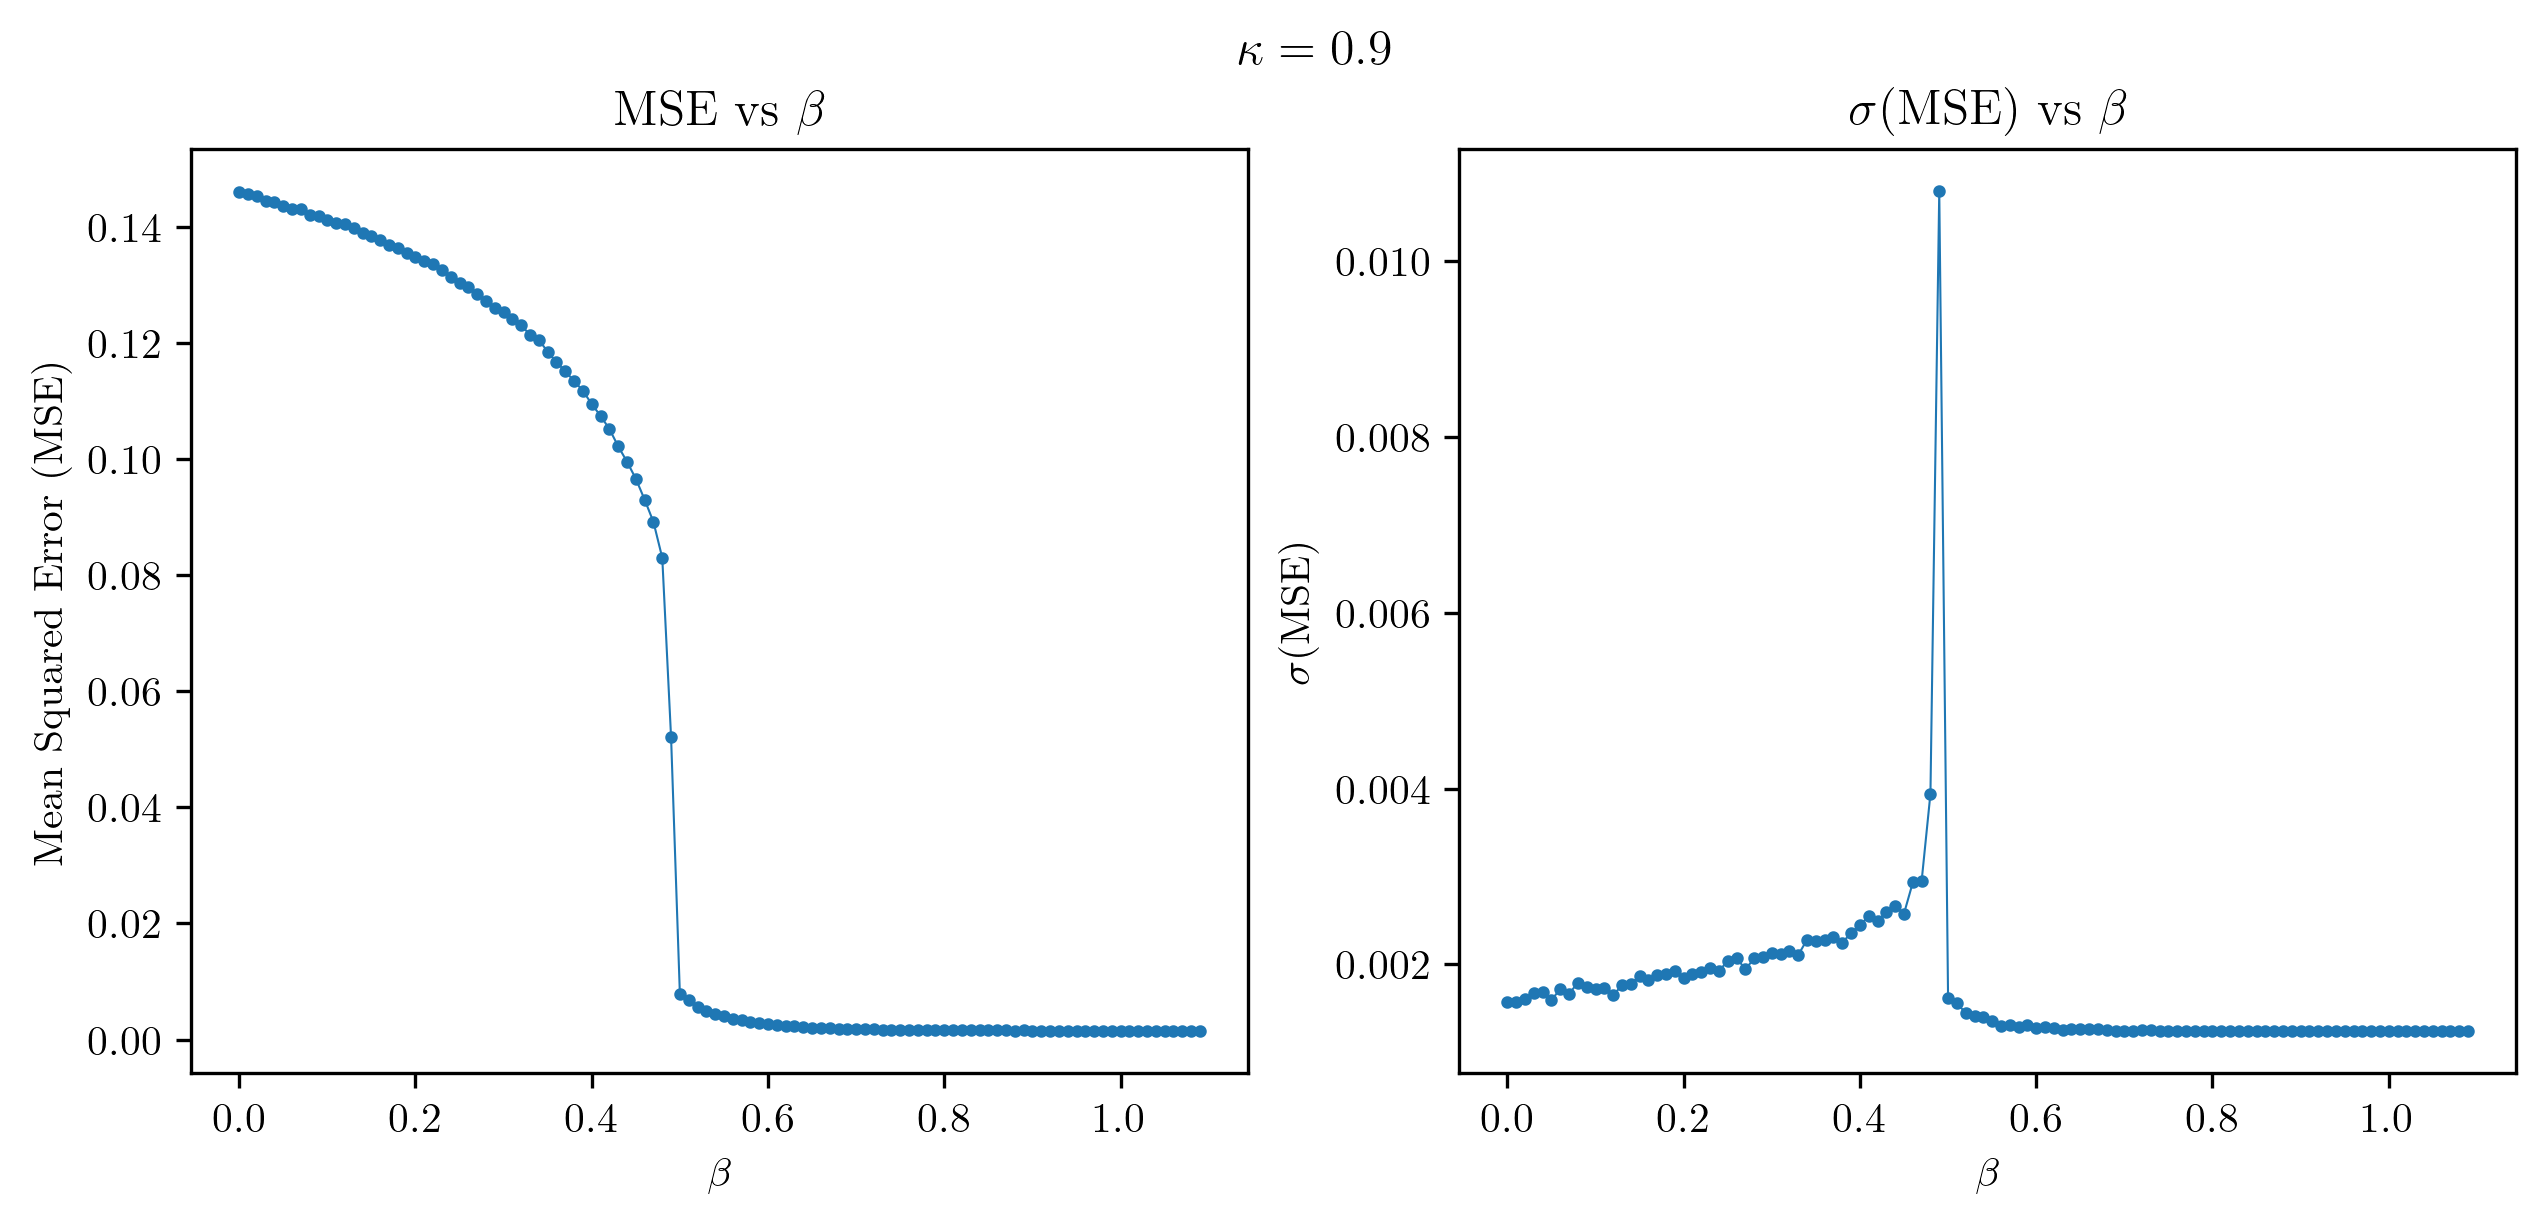

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(np.arange(0.0, 1.1, 0.01), testLossesMean[:], linewidth=0.5, marker='o', markersize=2)
ax[0].fill_between(np.arange(0.0, 1.1, 0.01), 
                 testLossesMean[:]-testLossesStd[:],
                 testLossesMean[:]+testLossesStd[:], alpha=0.2)
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Mean Squared Error (MSE)')
ax[0].set_title(r'MSE vs $\beta$')

ax[1].plot(np.arange(0.0, 1.1, 0.01), testLossesStd[:]*10, linewidth=0.5, marker='o', markersize=2)
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel(r'$\sigma$(MSE)')
ax[1].set_title(r'$\sigma$(MSE) vs $\beta$')


fig.suptitle(r'$\kappa={}$'.format(k))

plt.show()

In [ ]:
from functools import partial
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as v2
from torch.utils.data import random_split, DataLoader
from ray import tune, train
import tempfile
import torchDatasets as ds
from ray.train import Checkpoint
from ray.tune.schedulers import ASHAScheduler
# from torchvision.models import resnet50, resnet18
import networks as custNN
import matplotlib.pyplot as plt

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"

modelName = "Autoencoder"; side = 10
base_dir = '/home/shashank/Code/gonihedric/'; dataDir = base_dir + "data/ghData/"
trainScheme = "Autoencoder"
# criterion = nn.MSELoss()
criterion = nn.BCELoss()

class ConvAutoencoder(nn.Module):
    def __init__(self, channelMult=8, dropout=0.2):
        super(ConvAutoencoder, self).__init__()

        # self.drpt = nn.Dropout(dropout)
        # self.First = nn.Conv3d(1, 16, kernel_size=3, stride=2, padding=1),  # -> (16, H/2, W/2)
        # self.Second = nn.Conv3d(16, 24, kernel_size=3, stride=2, padding=1) # -> (8, H/4, W/4)
        # self.Third = nn.ConvTranspose3d(24, 40, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (8, H/4, W/4)
        # self.Fourth = nn.ConvTranspose3d(40, 48, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (16, H/2, W/2)
        # self.Fifth = nn.Conv3d(48, 1, kernel_size=3, stride=1, padding=1)
        # ----- Encoder -----
        self.encoder = nn.Sequential(
            nn.Conv3d(1, channelMult, kernel_size=3, stride=2, padding=1),  # -> (16, H/2, W/2)
            nn.BatchNorm3d(channelMult),
            nn.ReLU(True),

            nn.Dropout(dropout),
            nn.Conv3d(channelMult, 2*channelMult, kernel_size=3, stride=2, padding=1), # -> (8, H/4, W/4)
            nn.BatchNorm3d(2*channelMult),
            nn.ReLU(True)
        )

        # ----- Decoder -----
        self.decoder = nn.Sequential(
            nn.Dropout(dropout),
            nn.ConvTranspose3d(2*channelMult, channelMult, kernel_size=3, stride=2, padding=1, output_padding=0), # -> (8, H/4, W/4)
            nn.BatchNorm3d(channelMult),
            nn.ReLU(True),

            nn.Dropout(dropout),
            nn.ConvTranspose3d(channelMult, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (16, H/2, W/2)
            # nn.BatchNorm3d(1),
            # nn.ReLU(True),

            # nn.Dropout(dropout),
            # nn.Conv3d(48, 1, kernel_size=3, stride=1, padding=0),
            nn.Sigmoid()  # keeps output in [0,1] for binary images
        )

    def forward(self, x):
        # Encode
        x = self.encoder(x)
        x = self.decoder(x)
        return x

def load_data(data_dir, config):
    model = ConvAutoencoder(channelMult=16, dropout=0.2)
    if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
    else:
        model = model.to(device)
    
    trainset = ds.CustomAutoencoderDataset3D(data_dir+"trainL10k0.0", side)
    testset = ds.CustomAutoencoderDataset3D(data_dir+"testL10k0.0", side)
    return model, trainset, testset

def initialize_weights(model):
    nn.init.normal_(model.conv1.weight, 0, 0.1)
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.1)
            nn.init.constant_(m.bias, 0)


def trainFN(config):

    net, trainset, _ = load_data(dataDir, config)
    custNN.initialize_weights(net)
    
    # optimizer = optim.SGD(net.parameters(),lr=config["lr"],
    #                       momentum=config["momentum"],weight_decay=config["wd"])
    # optimizer = optim.Adam(net.parameters(),lr=config["lr"],weight_decay = config["wd"])

    optimizer = optim.Adam(net.parameters(),lr=config["lr"],weight_decay = config["wd"])
    # optimizer = optim.Adadelta(net.parameters(), lr=config["lr"], weight_decay=config["wd"])

    exp_lr_scheduler = None# optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=config["gamma"])

    # Load existing checkpoint through `get_checkpoint()` API.
    if train.get_checkpoint():
        loaded_checkpoint = train.get_checkpoint()
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            model_state, optimizer_state = torch.load(
                os.path.join(loaded_checkpoint_dir, "checkpoint.pt")
            )
            net.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = DataLoader( train_subset,
                             batch_size=config["batch_size"],
                             shuffle=True,
                             num_workers=4)
    valloader = DataLoader( val_subset,
                           batch_size=128,
                           shuffle=True,
                           num_workers=4)

    for epoch in range(50):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        net.train(); i = 0
        for inputs,_ in trainloader:
            inputs = inputs.to(device)

            optimizer.zero_grad() # zero the parameter gradients
            outputs = net(inputs).squeeze()
            loss = criterion(outputs, inputs.squeeze())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print(
                    "[%d, %5d] loss: %.3f"
                    % (epoch + 1, i + 1, running_loss / epoch_steps)
                )
                epoch_steps = 0
                running_loss = 0.0
                if exp_lr_scheduler is not None:
                    exp_lr_scheduler.step()
            i += 1

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        # correct = 0
        net.eval()
        with torch.no_grad():
            for inputs,_ in valloader:
                inputs = inputs.to(device)
                outputs = net(inputs)
                outputs = outputs.detach().squeeze().float()
                val_loss += criterion(outputs, inputs.squeeze()).cpu().numpy()
                val_steps += 1

# Here we save a checkpoint. It is automatically registered with
        # Ray Tune and will potentially be accessed through in ``get_checkpoint()``
        # in future iterations.
        # Note to save a file like checkpoint, you still need to put it under a directory
        # to construct a checkpoint.
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            path = os.path.join(temp_checkpoint_dir, "checkpoint.pt")
            torch.save(
                (net.state_dict(), optimizer.state_dict()), path
            )
            checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)
            train.report(
                {"loss": (val_loss / val_steps), 
                #  "accuracy": (correct / val_steps)
                 },
                checkpoint=checkpoint,
            )
    print("Finished Training")

def test_best_model(best_result):
    best_trained_model, _, testset = load_data(dataDir, best_result.config)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

    model_state, _ = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)

    testloader = DataLoader( testset, batch_size=128, 
                            shuffle=False, num_workers=4)

    correct = 0; total = 0; loss = 0
    best_trained_model.eval()
    with torch.no_grad():
        for inputs,_ in testloader:
            inputs = inputs.to(device)
            outputs = best_trained_model(inputs)
            outputs = outputs.detach().squeeze().float()
            loss += criterion(outputs, inputs.squeeze()).cpu().numpy()
            total += 1
    print("Best trial test set loss for \"{}\": {}".format(trainScheme, loss/total))

def main(num_samples=10, max_num_epochs=10, cpus_per_trial=6, gpus_per_trial=2):
    config = {
    "lr": tune.loguniform(5e-3, 5e-5),
    # "latentSpace": tune.choice([2, 4, 8, 16]),
    "batch_size": tune.choice([256, 512]),
    "wd": tune.loguniform(1e-1, 1e-6),
    # "activation": tune.choice([F.relu, F.sigmoid, F.tanh]),
    # "lam": tune.loguniform(1e-1, 1e-5),
    # "momentum": tune.uniform(0.1, 1.0),
    # "amsgrad": tune.choice([True, False]),
    "dropout": tune.uniform(0.0, 0.2),
    }
    print(modelName + " with SGD for OP side:"+str(side))
    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2
    )
    tuner = tune.Tuner(
         tune.with_resources(
            tune.with_parameters(trainFN),
            resources={"cpu": cpus_per_trial, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
        ),
        param_space=config,
    )
    results = tuner.fit()
    best_result = results.get_best_result("loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["loss"]))
    test_best_model(best_result)

In [2]:
main(num_samples=20, max_num_epochs=100, gpus_per_trial=1)

(trainFN pid=369600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00000_0_batch_size=512,dropout=0.2489,lr=0.4452,wd=0.0015_2026-02-03_17-50-41/checkpoint_000000)
(trainFN pid=369600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00000_0_batch_size=512,dropout=0.2489,lr=0.4452,wd=0.0015_2026-02-03_17-50-41/checkpoint_000001)
(trainFN pid=369600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00000_0_batch_size=512,dropout=0.2489,lr=0.4452,wd=0.0015_2026-02-03_17-50-41/checkpoint_000002)
(trainFN pid=369600) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00000_0_batch_size=512,dropout=0.2489,lr=0.4452,wd=0.0015_2026-02-03_

(trainFN pid=369600) Finished Training


(trainFN pid=371333) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00001_1_batch_size=128,dropout=0.4296,lr=0.0003,wd=0.0297_2026-02-03_17-50-41/checkpoint_000000)
(trainFN pid=371430) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00002_2_batch_size=128,dropout=0.3409,lr=0.1446,wd=0.0009_2026-02-03_17-50-41/checkpoint_000001) [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(trainFN pid=371430) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00002_2_batch_size=128,dropout=0.3409,lr=0.1446,wd=0.0009_2026-02-03_17-50-41/checkp

(trainFN pid=371430) Finished Training


(trainFN pid=373212) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00004_4_batch_size=512,dropout=0.1447,lr=0.3274,wd=0.0071_2026-02-03_17-50-41/checkpoint_000000) [repeated 2x across cluster]
(trainFN pid=373341) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00005_5_batch_size=256,dropout=0.0832,lr=0.0005,wd=0.0000_2026-02-03_17-50-41/checkpoint_000000) [repeated 2x across cluster]
(trainFN pid=373341) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00005_5_batch_size=256,dropout=0.0832,lr=0.0005,wd=0.0000_2026-02-03_17-50-41/checkpoint_000004) [repeated 4x across cluster]
(trainFN pid=373341) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50

(trainFN pid=373341) Finished Training


(trainFN pid=375378) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00006_6_batch_size=512,dropout=0.4288,lr=0.0017,wd=0.0000_2026-02-03_17-50-41/checkpoint_000000) [repeated 2x across cluster]
(trainFN pid=375508) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00007_7_batch_size=128,dropout=0.2259,lr=0.0621,wd=0.0005_2026-02-03_17-50-41/checkpoint_000000) [repeated 2x across cluster]
(trainFN pid=375508) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00007_7_batch_size=128,dropout=0.2259,lr=0.0621,wd=0.0005_2026-02-03_17-50-41/checkpoint_000004) [repeated 4x across cluster]
(trainFN pid=375508) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50

(trainFN pid=375508) Finished Training


(trainFN pid=377188) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00008_8_batch_size=128,dropout=0.1440,lr=0.0021,wd=0.0002_2026-02-03_17-50-41/checkpoint_000000) [repeated 2x across cluster]
(trainFN pid=377188) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00008_8_batch_size=128,dropout=0.1440,lr=0.0021,wd=0.0002_2026-02-03_17-50-41/checkpoint_000004) [repeated 4x across cluster]
(trainFN pid=377188) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00008_8_batch_size=128,dropout=0.1440,lr=0.0021,wd=0.0002_2026-02-03_17-50-41/checkpoint_000008) [repeated 4x across cluster]
(trainFN pid=377188) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50

(trainFN pid=377188) Finished Training


(trainFN pid=378882) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00009_9_batch_size=128,dropout=0.3691,lr=0.0009,wd=0.0006_2026-02-03_17-50-41/checkpoint_000000) [repeated 2x across cluster]
(trainFN pid=378882) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00009_9_batch_size=128,dropout=0.3691,lr=0.0009,wd=0.0006_2026-02-03_17-50-41/checkpoint_000004) [repeated 4x across cluster]
(trainFN pid=379205) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00010_10_batch_size=128,dropout=0.2082,lr=0.0001,wd=0.0117_2026-02-03_17-50-41/checkpoint_000000) [repeated 4x across cluster]
(trainFN pid=379301) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-5

(trainFN pid=379724) Finished Training


(trainFN pid=379724) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00013_13_batch_size=128,dropout=0.1443,lr=0.1327,wd=0.0001_2026-02-03_17-50-41/checkpoint_000049) [repeated 4x across cluster]
(trainFN pid=381419) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00014_14_batch_size=512,dropout=0.2893,lr=0.0044,wd=0.0000_2026-02-03_17-50-41/checkpoint_000001) [repeated 2x across cluster]
(trainFN pid=381419) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00014_14_batch_size=512,dropout=0.2893,lr=0.0044,wd=0.0000_2026-02-03_17-50-41/checkpoint_000005) [repeated 4x across cluster]
(trainFN pid=381419) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17

(trainFN pid=382096) Finished Training


(trainFN pid=383780) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00017_17_batch_size=128,dropout=0.1581,lr=0.0086,wd=0.0019_2026-02-03_17-50-41/checkpoint_000001) [repeated 2x across cluster]
(trainFN pid=383780) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00017_17_batch_size=128,dropout=0.1581,lr=0.0086,wd=0.0019_2026-02-03_17-50-41/checkpoint_000005) [repeated 4x across cluster]
(trainFN pid=383780) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00017_17_batch_size=128,dropout=0.1581,lr=0.0086,wd=0.0019_2026-02-03_17-50-41/checkpoint_000009) [repeated 4x across cluster]
(trainFN pid=383780) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17

(trainFN pid=383780) Finished Training


(trainFN pid=383780) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00017_17_batch_size=128,dropout=0.1581,lr=0.0086,wd=0.0019_2026-02-03_17-50-41/checkpoint_000049) [repeated 4x across cluster]
2026-02-03 18:01:35,686	INFO tune.py:1009 -- Wrote the latest version of all result files and experiment state to '/home/shashank/ray_results/trainFN_2026-02-03_17-50-40' in 0.0062s.
2026-02-03 18:01:35,691	INFO tune.py:1041 -- Total run time: 653.91 seconds (653.89 seconds for the tuning loop).


Best trial config: {'lr': 0.002065691663432126, 'batch_size': 128, 'wd': 0.00016894053078186604, 'dropout': 0.14404089356326266}
Best trial final validation loss: 0.1504010260105133


(trainFN pid=385751) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/shashank/ray_results/trainFN_2026-02-03_17-50-40/trainFN_79b76_00019_19_batch_size=64,dropout=0.2581,lr=0.3901,wd=0.0002_2026-02-03_17-50-41/checkpoint_000000) [repeated 2x across cluster]


Best trial test set loss for "Autoencoder": 0.15065325796604156


In [1]:
from utilsTrainTest import visualize_reconstruction
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchDatasets as ds
import matplotlib.pyplot as plt
import torch as T
side = 10
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['figure.dpi']= 300
class ConvAutoencoder(nn.Module):
    def __init__(self, dropout=0.2):
        super(ConvAutoencoder, self).__init__()
        # ----- Encoder -----
        self.encoder = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=3, stride=2, padding=1),  # -> (16, H/2, W/2)
            nn.BatchNorm3d(8),
            nn.ReLU(True),

            nn.Dropout(dropout),
            nn.Conv3d(8, 16, kernel_size=3, stride=2, padding=1), # -> (8, H/4, W/4)
            nn.BatchNorm3d(16),
            nn.ReLU(True)
        )

        # ----- Decoder -----
        self.decoder = nn.Sequential(
            nn.Dropout(dropout),
            nn.ConvTranspose3d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=0), # -> (8, H/4, W/4)
            nn.BatchNorm3d(8),
            nn.ReLU(True),

            nn.Dropout(dropout),
            nn.ConvTranspose3d(8, 1, kernel_size=3, stride=2, padding=1, output_padding=1), # -> (16, H/2, W/2)
            nn.Sigmoid()  # keeps output in [0,1] for binary images
        )

    def forward(self, x):
        # Encode
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ConvAutoencoder(0.2)
device = "cpu"
if T.cuda.is_available():
    device = "cuda"
batchSize = 100
dataDir = '/home/shashank/Code/gonihedric/data/ghData/'

In [24]:
print(tmpCount)

[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 2000    0 1000 1000
 1000 1000 2000    0 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000 1000
 1000 1000 1000 1000 1000 1000 2000 1000    0 1000 1000 1000]


In [43]:
for t,n in zip(np.unique(uniqueTmps), tmpCount):
    print(f"C={np.round(t*100).astype(int)}, r={t}, Count={n}")
    # print(f"T={t:.2f}, Count={n}")

C=0, r=0.0, Count=1000
C=1, r=0.009999999776482582, Count=1000
C=2, r=0.019999999552965164, Count=1000
C=3, r=0.029999999329447746, Count=1000
C=4, r=0.03999999910593033, Count=1000
C=5, r=0.05000000074505806, Count=1000
C=6, r=0.05999999865889549, Count=1000
C=7, r=0.07000000029802322, Count=1000
C=8, r=0.07999999821186066, Count=1000
C=9, r=0.09000000357627869, Count=1000
C=10, r=0.10000000149011612, Count=1000
C=11, r=0.10999999940395355, Count=1000
C=12, r=0.11999999731779099, Count=1000
C=13, r=0.12999999523162842, Count=1000
C=14, r=0.14000000059604645, Count=1000
C=15, r=0.15000000596046448, Count=1000
C=16, r=0.1599999964237213, Count=1000
C=17, r=0.17000000178813934, Count=1000
C=18, r=0.18000000715255737, Count=1000
C=19, r=0.1899999976158142, Count=1000
C=20, r=0.20000000298023224, Count=1000
C=21, r=0.20999999344348907, Count=1000
C=22, r=0.2199999988079071, Count=1000
C=23, r=0.23000000417232513, Count=1000
C=24, r=0.23999999463558197, Count=1000
C=25, r=0.25, Count=1000
C

In [45]:
for t,n in zip(np.unique(uniqueTmps), tmpCount):
    print(t,n)

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000
10 1000
11 1000
12 1000
13 1000
14 1000
15 1000
16 1000
17 1000
18 1000
19 1000
20 1000
21 1000
22 1000
23 1000
24 1000
25 1000
26 1000
27 1000
28 1000
29 1000
30 1000
31 1000
32 1000
33 1000
34 1000
35 1000
36 1000
37 1000
38 1000
39 1000
40 1000
41 1000
42 1000
43 1000
44 1000
45 1000
46 1000
47 1000
48 1000
49 1000
50 1000
51 1000
52 1000
53 1000
54 1000
55 1000
56 1000
57 1000
58 1000
59 1000
60 1000
61 1000
62 1000
63 1000
64 1000
65 1000
66 1000
67 1000
68 1000
69 1000
70 1000
71 1000
72 1000
73 1000
74 1000
75 1000
76 1000
77 1000
78 1000
79 1000
80 1000
81 1000
82 1000
83 1000
84 1000
85 1000
86 1000
87 1000
88 1000
89 1000
90 1000
91 1000
92 1000
93 1000
94 1000
95 1000
96 1000
97 1000
98 1000
99 1000
100 1000
101 1000
102 1000
103 1000
104 1000
105 1000
106 1000
107 1000
108 1000
109 1000


In [24]:
modelSnapshot="/home/shashank/Code/gonihedric/data/ghData/checkpoints/Autoencoder/2026-02-02_14-14-55 ISING/1/best_model.pth"
model.load_state_dict(T.load(modelSnapshot, map_location=device))
model = model.to(device)
model.eval()

temperatures = np.arange(0.0, 1.1, 0.01)
testLossesMean = np.empty(len(temperatures))
testLossesStd = np.empty(len(temperatures))
batchSize = 1000
k = 0.9

dataset = ds.CustomAutoencoderDataset3D(dataDir+"testIsing", side) #2DGH32
testLoader = T.utils.data.DataLoader(dataset, batch_size=batchSize, shuffle=False)
model.eval()
j = 0
# uniqueTmps = []
tmpCount = np.zeros(len(temperatures), dtype=int); tmpLosses = np.empty([len(temperatures), 1000])
with T.no_grad():
    for batch_idx, (images,label) in enumerate(testLoader):
        images = images.to(device)
        label = label.numpy()
        outputs = model(images)
        loss = F.mse_loss(outputs, images, reduction='none').mean((2,3,4)).squeeze().cpu().numpy()
        for i in range(len(loss)):
            tmpLosses[np.round(label[i]*100).astype(int), tmpCount[np.round(label[i]*100).astype(int)]] = loss[i]
            tmpCount[np.round(label[i]*100).astype(int)] += 1
            # uniqueTmps.append(np.round(label[i]*100).astype(int))
testLossesMean = np.mean(tmpLosses, axis=1)
testLossesStd = np.std(tmpLosses, axis=1)/np.sqrt(tmpCount)


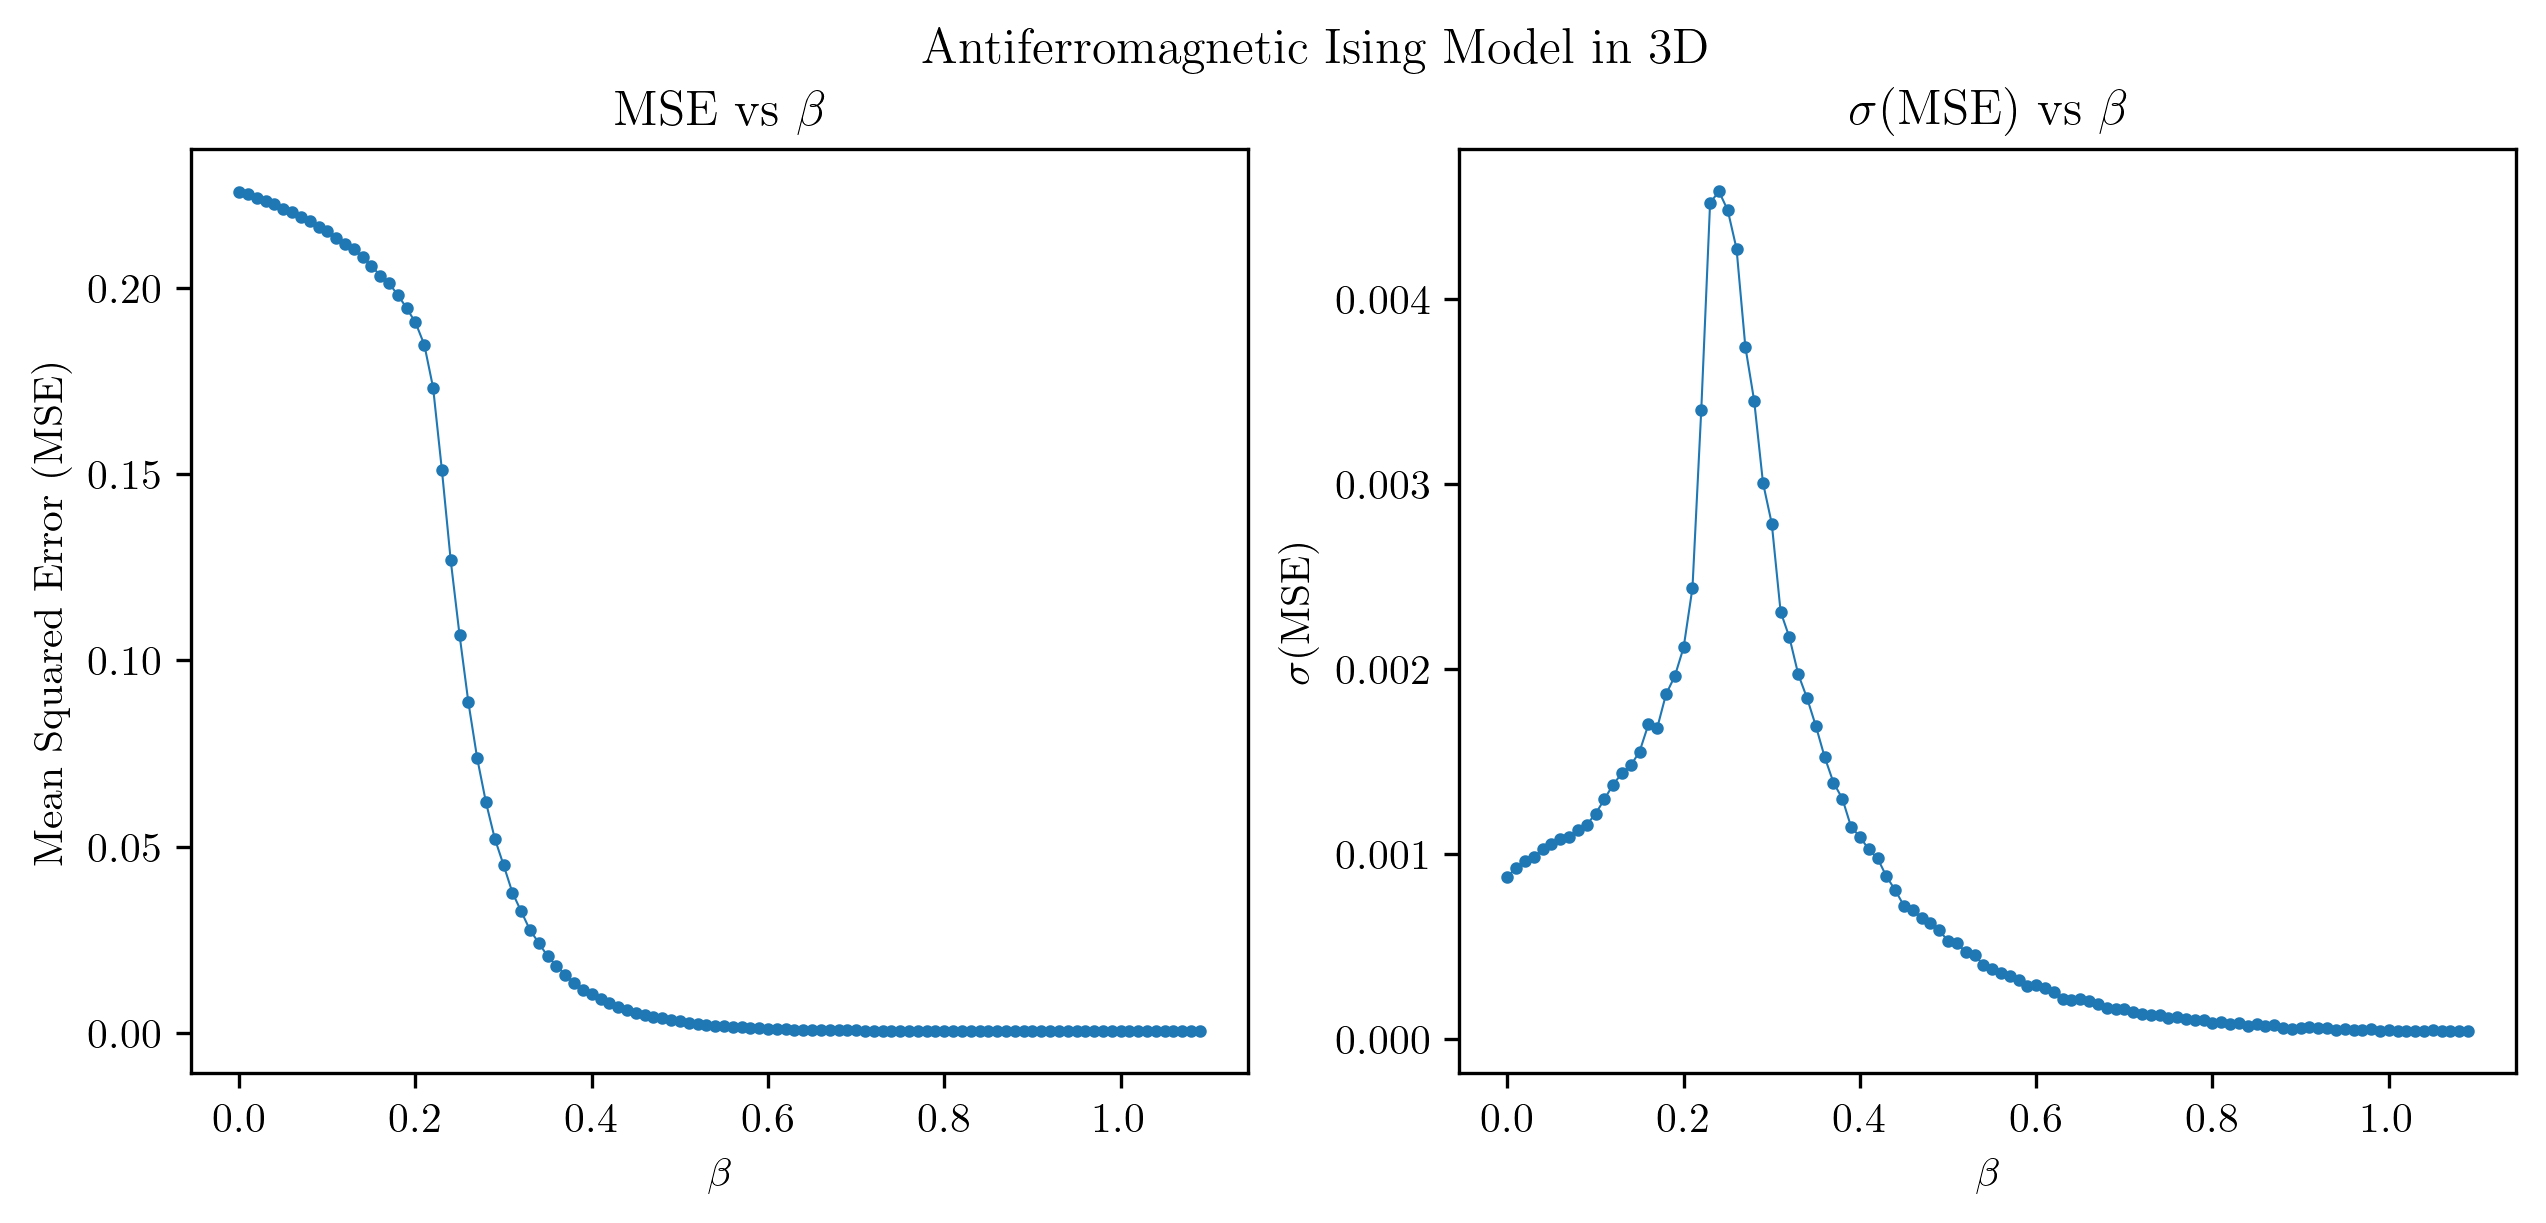

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

ax[0].plot(np.arange(0.0, 1.1, 0.01), testLossesMean[:], linewidth=0.5, marker='o', markersize=2)
ax[0].fill_between(np.arange(0.0, 1.1, 0.01), 
                 testLossesMean[:]-testLossesStd[:],
                 testLossesMean[:]+testLossesStd[:], alpha=0.2)
ax[0].set_xlabel(r'$\beta$')
ax[0].set_ylabel('Mean Squared Error (MSE)')
ax[0].set_title(r'MSE vs $\beta$')

ax[1].plot(np.arange(0.0, 1.1, 0.01), testLossesStd[:]*10, linewidth=0.5, marker='o', markersize=2)
ax[1].set_xlabel(r'$\beta$')
ax[1].set_ylabel(r'$\sigma$(MSE)')
ax[1].set_title(r'$\sigma$(MSE) vs $\beta$')


fig.suptitle(r'Antiferromagnetic Ising Model in 3D')

plt.show()

In [26]:
2/np.log(1+np.sqrt(2))

np.float64(2.269185314213022)

In [45]:
np.pow(8, 1.4)

np.float64(18.379173679952558)

In [42]:
T_C = 2/(np.log(1+np.sqrt(2)))
val = T_C - 0.4
print(T_C-0.4, T_C+0.4)
for t in np.linspace(T_C-0.4, T_C+0.4, 114):
    print(np.isclose(t, val, atol=0.000001))
    val += 0.8/(114-1)


1.8691853142130221 2.669185314213022
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
